# VRE for a multiparametric analysis of the Amatrice-Norcia Italian seismic sequence 2016-2017

## MINI ABSTRACT  

The study presents the development of a Virtual Research Environment (VRE) for analyzing the 2016 Amatrice-Norcia seismic sequence using a multidisciplinary approach. Implemented through Jupyter Notebooks, the VRE enables researchers to reproduce analyses, modify parameters, and visualize results interactively. It leverages the European Plate Observing System (EPOS) platform, which integrates diverse geophysical datasets. The system accesses earthquake data via EPOS APIs and could potentially be deployed as software within the EPOS portal in the future.

## IMPLEMENTATION OVERVIEW
### Data 
The VRE at this preliminary stage of implementation uses for:
1. __Lithosphere:__ earthquake catalogue retrieved by EPOS; GNSS station positions retrieved by EPOS;
2. **Atmosphere:** Climitological measurements from MERRA-2 archive by NASA (parameters: SO_2, dimetil sulphid, aerosol optical thickness, CO, Surface Air Temperature, relative humidity, Surface Latent Heat Flux, Total Precipitation);
3. **Ionosphere:**  Swarm three identical satellite magnetic data 

### Analyses workflow 
1. Lithospheric analysis  
2. Atmospheric analysis
3. Ionospheric analysis
4. Comparison of the three Geo-layers

### Reconfigurable parameters
The VRE is reconfigurable for another target earthquake (possible limitation for events close to -180 or +180 longitude) changing:
1. **Earthquake origin time:** EQ_year, EQ_month, EQ_day, EQ_hour, EQ_minute, EQ_second;
2. **earthquake magnitude:** EQ_mag;
3. **Epicentral coordinates:** epilat, epilon.
4. **Hypocentral depth:** EQ_depth
5. **Fault strike:** Fault_strike (this is the angle of orientation of the fault determined from one of the two nodal planes of focal mechanism solution). 
It's also possible to change the time to be analysed before and after the target earthquake (in days):
6. **day before the earthquake:** day_before;
7. **day after the earthquake:** day_after

In [1]:
% Global variables initialization

% Earthquake origin time
EQ_year = 2016; EQ_month=8; EQ_day=24; EQ_hour=1; EQ_minute=36; EQ_second = 32;
%Epicenter latitude and longitude
epilat = 42.6980; epilon = 13.2340;
%Mainshock magnitude
EQ_mag = 6.5;
EQ_depth = 10;
Fault_strike = 153; %Here is inserted a mean strike of the two main faults: Amatrice 155 and Norcia 151
%This strike must be a positive value
day_before = 8*30;
day_after = 0;

Please, make sure that the Matlab current folder is the one with this Jupyter notebook file (VRE_Amatrice_v1.5.ipynb)

In [2]:
current_folder = pwd

current_folder = 'C:\Users\dedal'

In [3]:
cd(fullfile(current_folder, 'VRE_Amatrice_GitHub'));

# Lithospheric analysis 
## step 1
1. Lithospheric analysis
1.1  
we retrieve the seismic catalogue to study the Lithosphere from the EPOS Platform

In [4]:
format compact

EQ_time = datenum([EQ_year, EQ_month, EQ_day, EQ_hour, EQ_minute, EQ_second]);
time_start = EQ_time - day_before;
time_end = EQ_time + day_after;
radius_Dobrovolsky = 10.^(0.43*EQ_mag)/111;
min_lat = epilat - radius_Dobrovolsky - 5;
max_lat = epilat + radius_Dobrovolsky + 5;
min_lon = epilon - radius_Dobrovolsky - 5;
max_lon = epilon + radius_Dobrovolsky + 5;
%Minimun magnitude to be retrieved by the catalogue
EQ_min_mag= 1.0;
EQ = [];
for time_tba = time_start:time_end-1
    time_tba_end = time_tba + (23+59/60.0+59/3600.0)/24;
    weburl_to_retrive_the_data = ['https://www.seismicportal.eu/fdsnws/event/1/query?starttime=', datestr(time_tba, 'yyyy-mm-dd'), 'T',  datestr(time_tba, 'HH'),':', datestr(time_tba, 'MM'), ':', datestr(time_tba, 'SS'),'Z&endtime=', datestr(time_tba_end, 'yyyy-mm-dd'), 'T', datestr(time_tba_end, 'HH'),':', datestr(time_tba_end, 'MM'), ':', datestr(time_tba_end, 'SS'), 'Z&minmagnitude=', num2str(EQ_min_mag, '%.1f'), '&minlatitude=', num2str(min_lat, '%.4f'), '&maxlatitude=', num2str(max_lat, '%.4f'), '&minlongitude=', num2str(min_lon, '%.4f'), '&maxlongitude=', num2str(max_lon, '%.4f'), '&includeallorigins=false&includearrivals=false&limit=480&format=json&nodata=204'];%'&preferredOnly=true&format=text&limit=2500'];
    EQ_p = webread(weburl_to_retrive_the_data);
    EQ = [EQ; EQ_p];
end
disp(EQ)


  240x1 struct array with fields:
    type
    metadata
    features


The following part, convert the earthquake catalogue in an array with the ZMap (Wiemer, 2001) standard, that  is:
longitude | latitude | year | month | day | magnitude | depth | hour | minute | second

<b> References: </b>
Wiemer, S. A Software Package to Analyze Seismicity: ZMAP. Seismological Research Letters 2001, 72, 373–382, doi:10.1785/gssrl.72.3.373.



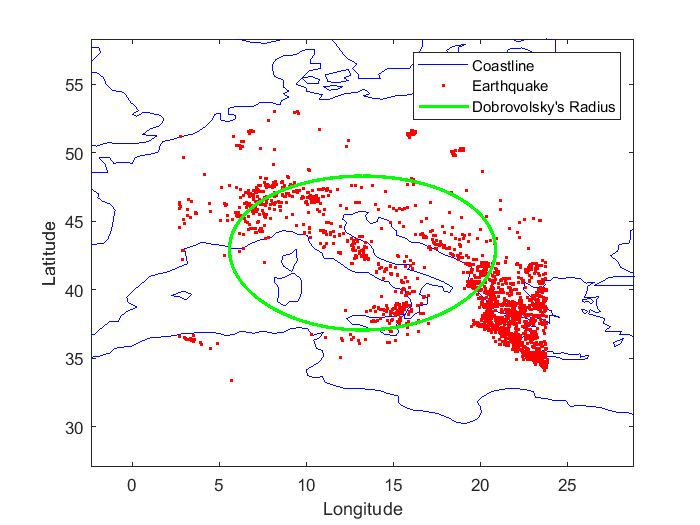

In [6]:
format compact
k=1;
EQ_new = nan(size(EQ,1)*3,10);
for i = 1:size(EQ,1)
    EQ_temp = EQ(i).features;
    for j = 1:size(EQ_temp,1)
        hypocenter = EQ_temp(j).geometry.coordinates;
        EQ_magnitude = EQ_temp(j).properties.mag;
        EQ_origin_time = EQ_temp(j).properties.time;
        EQ_origin_time_1 = datetime([EQ_origin_time(1:10), ' ', EQ_origin_time(12:21)]);
        EQ_origin_time_vector = datevec(EQ_origin_time_1);
        EQ_new(k,:) = [hypocenter(1:2)', EQ_origin_time_vector(1:3), EQ_magnitude, -hypocenter(3), EQ_origin_time_vector(4:6)];
        k = k + 1;
    end
end
EQ_new = EQ_new(1:k-1,:);
figure
load coastlines
plot(coastlon, coastlat, '-b')
hold on
plot(EQ_new(:,1), EQ_new(:,2), '.r');
[aas,bbs]=scircle1(epilat,epilon,radius_Dobrovolsky);
plot(bbs,aas,'-g', 'LineWidth',2);
axis([min_lon-5 max_lon+5 min_lat-5 max_lat+5]); 
xlabel('Longitude')
ylabel('Latitude')
legend('Coastline', 'Earthquake', ['Dobrovolsky', 39 ,'s Radius']);

# Selection of earthquakes of interest
In the following lines, only the most interesting earthquakes are selected. In fact, we will consider a circular area defined by Dobrovolsky's Radius (km) = $10^{0.43 \times MAG}$ (Dobrovolsky et al., 1979). This is one of the possible areas that define the preparation of an earthquake, but it's widely used, and it corresponds to the distance where the seismic shaking is equal to the terrestrial tidal deformation.

In addition, we need to select only the earthquakes with a magnitude equal to or greater than the completeness magnitude of the earthquake catalogue.  
Last but not least, a selection of shallow earthquakes can be applied as deeper events are unlikely related to the interactions with the atmosphere and ionosphere. 

<b> References: </b>  
Dobrovolsky, I.P.; Zubkov, S.I.; Miachkin, V.I. Estimation of the Size of Earthquake Preparation Zones. PAGEOPH 1979, 117, 1025–1044, doi:10.1007/BF00876083.


In [7]:
distance_from_target_EQ = distance(epilat, epilon, EQ_new(:,2), EQ_new(:,1));
EQ_sel = EQ_new(distance_from_target_EQ <= radius_Dobrovolsky, :);
distance_from_target_EQ = distance_from_target_EQ(distance_from_target_EQ <= radius_Dobrovolsky);

Completeness_magnitude = 2.0; % From ZMap using Max curvature criterium
%in a future update, the MC can be calculated inside the VRE

distance_from_target_EQ = distance_from_target_EQ(EQ_sel(:,6) >= Completeness_magnitude);
EQ_sel = EQ_sel(EQ_sel(:,6) >= Completeness_magnitude, :);

max_depth = 50;
distance_from_target_EQ = distance_from_target_EQ(EQ_sel(:,7) <= max_depth);
EQ_sel = EQ_sel(EQ_sel(:,7) <= max_depth, :);

size(EQ_sel,1)

ans = 591

# Calculus of Cumulative Benioff Strain 

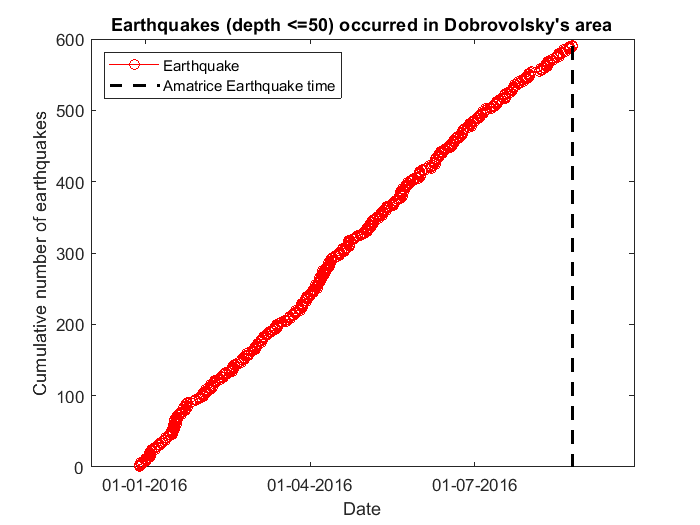

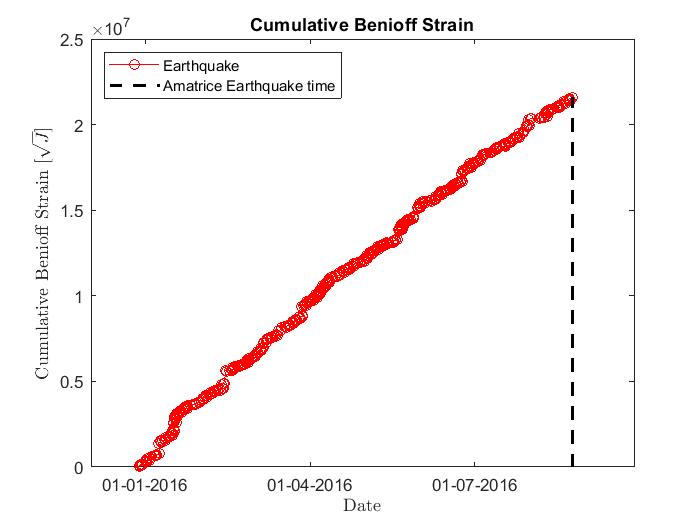

In [8]:
cumulative_number = (1:size(EQ_sel,1))';
time_EQ_sel = datenum([EQ_sel(:,3:5), EQ_sel(:,8:10)]); 

figure;
plot(time_EQ_sel, cumulative_number, '-or');
datetick('x', 'dd-mm-yyyy', 'keeplimits');
line([EQ_time, EQ_time], [0 cumulative_number(end)+1], 'LineStyle', '--', 'LineWidth', 2, 'Color', 'k');
xlabel('Date')
ylabel('Cumulative number of earthquakes');
title(['Earthquakes (depth <=', num2str(max_depth), ') occurred in Dobrovolsky', 39, 's area']);
legend('Earthquake', 'Amatrice Earthquake time', 'Location', 'NorthWest')


EQ_energy = 10.^(1.5*EQ_sel(:,6)+4.8);

EQ_sqrt_energy = nan(size(EQ_sel,1),1);
EQ_sqrt_energy(1,1) = sqrt(EQ_energy(1));
for i=2:size(EQ_sel, 1)
EQ_sqrt_energy(i,1) = EQ_sqrt_energy(i-1,1) + sqrt(EQ_energy(i));
end

figure;
plot(time_EQ_sel, EQ_sqrt_energy, '-or');
datetick('x', 'dd-mm-yyyy', 'keeplimits');
line([EQ_time, EQ_time], [0 EQ_sqrt_energy(end)], 'LineStyle', '--', 'LineWidth', 2, 'Color', 'k');
xlabel('Date', 'Interpreter', 'latex')
ylabel('Cumulative Benioff Strain [$\sqrt{J}$]', 'Interpreter', 'latex');
title(['Cumulative Benioff Strain']);
legend('Earthquake', 'Amatrice Earthquake time', 'Location', 'NorthWest')



# Earthquake released energy as a function of the distance to the target earthquake
In the following, the earthquake released energy is weighted with the square distance to the incoming earthquake, according to the parameter $E_S$ introduced by prof. Katsumi Hattori (e.g., Hattori et al., 2013):  
$E_S = \sum_i{E_i \over r^2}$  
The parameter $E_S$ is calculated on all i-th events occurred in a single day.  
The concept is that an earthquake that happened closer to the future larger target is more important than one which is far.

<b> References: </b>  
Hattori, K.; Han, P.; Yoshino, C.; Febriani, F.; Yamaguchi, H.; Chen, C.-H. Investigation of ULF Seismo-Magnetic Phenomena in Kanto, Japan During 2000–2010: Case Studies and Statistical Studies. Surv Geophys 2013, 34, 293–316, doi:10.1007/s10712-012-9215-x.


number_of_analysed_days = 241

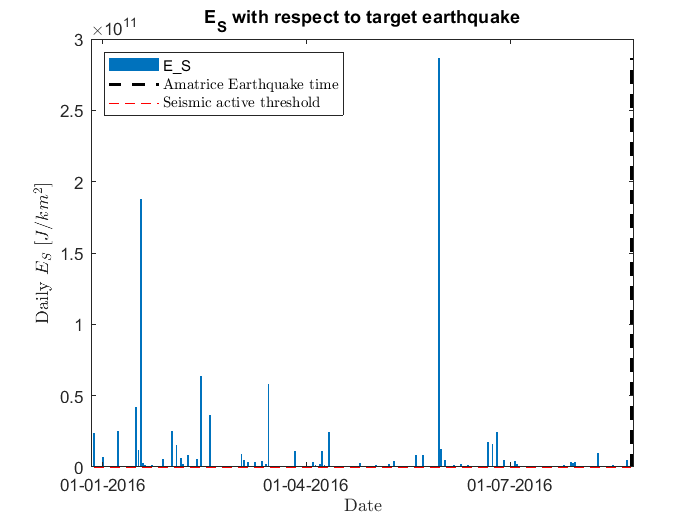

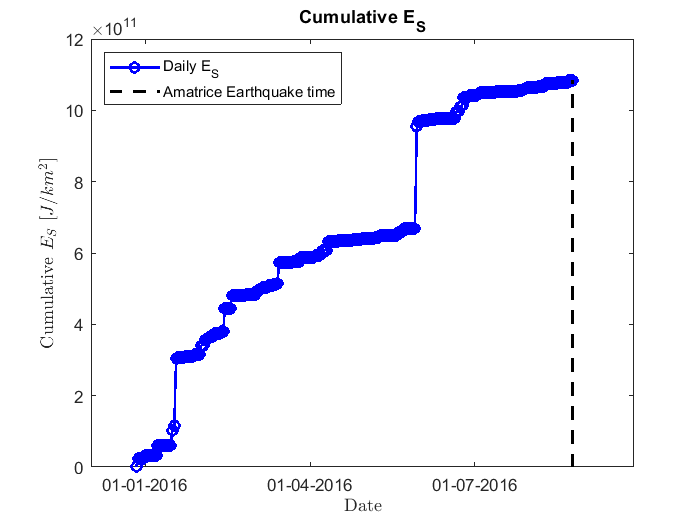

In [9]:
EQ_energy_for_ES = EQ_energy ./ (distance_from_target_EQ.^2);
day_start = fix(time_start);
day_end = fix(time_end);
number_of_analysed_days = day_end - day_start + 1
ES_Daily = zeros(number_of_analysed_days, 2);
k = 1;
for day_to_analysed = day_start:day_end
    [year_tba, month_tba, day_tba] = datevec(day_to_analysed);
    ES_Daily(k, :) = [day_to_analysed, sum(EQ_energy_for_ES(EQ_sel(:,3) == year_tba & EQ_sel(:,4) == month_tba & EQ_sel(:,5) == day_tba))];
    k = k + 1;
end

figure;
bar(ES_Daily(:,1), ES_Daily(:,2));
datetick('x', 'dd-mm-yyyy', 'keeplimits');
line([EQ_time, EQ_time], [0 max(ES_Daily(:,2))], 'LineStyle', '--', 'LineWidth', 2, 'Color', 'k');
line([day_start, day_end], [1e8, 1e8], 'LineStyle', '--', 'LineWidth', 1, 'Color', 'r');
xlabel('Date', 'Interpreter', 'latex')
ylabel('Daily $E_S$ [$J/km^2$]', 'Interpreter', 'latex');
title(['E_S with respect to target earthquake']);
legend('E_S', 'Amatrice Earthquake time', 'Seismic active threshold', 'Location', 'NorthWest', 'Interpreter', 'latex')

cumulative_ES = zeros(size(ES_Daily,1)+1,2);
cumulative_ES(1,1) = day_start - 1;
k = 2;
for i = 1:size(ES_Daily, 1)
    cumulative_ES(k,:) = [ES_Daily(i,1), cumulative_ES(k-1, 2)+ES_Daily(i,2)];
    k = k + 1;
end

figure
plot(cumulative_ES(:,1), cumulative_ES(:,2), '-ob', 'Linewidth', 1.5);
datetick('x', 'dd-mm-yyyy', 'keeplimits');
line([EQ_time, EQ_time], [0 cumulative_ES(end)], 'LineStyle', '--', 'LineWidth', 2, 'Color', 'k');
xlabel('Date', 'Interpreter', 'latex')
ylabel('Cumulative $E_S$ [$J/km^2$]', 'Interpreter', 'latex');
title(['Cumulative E_S']);
legend('Daily E_S', 'Amatrice Earthquake time', 'Location', 'NorthWest')

# Analysis of vatiations of plates movements from EPOS GNSS Positions 

number_of_GNSS_stations = 304

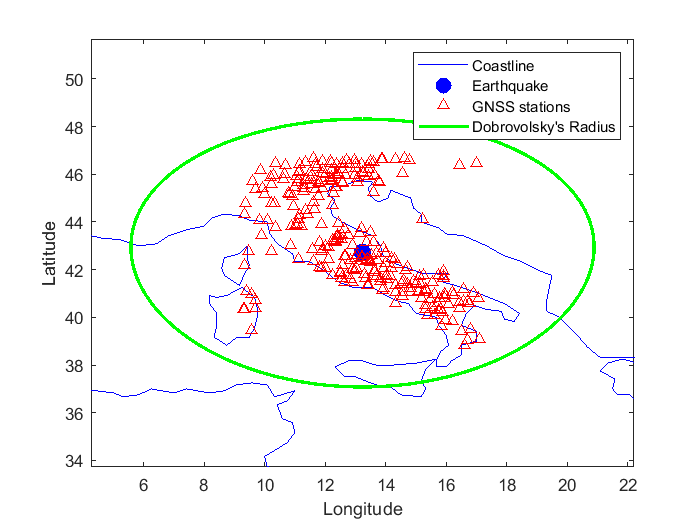

In [5]:
EQ_time = datenum([EQ_year, EQ_month, EQ_day, EQ_hour, EQ_minute, EQ_second]);
time_start = EQ_time - day_before;
time_end = EQ_time + day_after;
[year_start, month_start, day_start] = datevec(time_start);
[year_end, month_end, day_end] = datevec(time_end);
radius_Dobrovolsky = 10.^(0.43*EQ_mag)/111;
min_lat = epilat - radius_Dobrovolsky/sqrt(2);
max_lat = epilat + radius_Dobrovolsky/sqrt(2);
min_lon = epilon - radius_Dobrovolsky/sqrt(2);
max_lon = epilon + radius_Dobrovolsky/sqrt(2);

weburl_to_retrive_the_GNSS_station_list = ['https://gnssproducts.epos.ubi.pt/glass/products/velocities/geojson/SGO-EPND/', num2str(min_lon, '%.4f'), '/', num2str(min_lat, '%.4f'), '/', num2str(max_lon, '%.4f'), '/', num2str(max_lat, '%.4f'), '/'];
GNSS_station_list = webread(weburl_to_retrive_the_GNSS_station_list);
data_from_GNSS = {};
k_GNSS = 1;
if size(GNSS_station_list, 1) > 0
    GNSS_station_list = GNSS_station_list.features;
    number_of_GNSS_stations = size(GNSS_station_list, 1)
    if number_of_GNSS_stations > 0
        coordinates_of_GNSS = nan(number_of_GNSS_stations, 2);
        for i = 1:number_of_GNSS_stations
%It's necessary to insert test of time avaliability
            coordinates_of_GNSS(i,1) = GNSS_station_list(i).properties.Longitude;
            coordinates_of_GNSS(i,2) = GNSS_station_list(i).properties.Latitude;
            weburl_to_retrive_the_data = ['https://gnssproducts.epos.ubi.pt/GlassFramework/webresources/products/timeseries/', GNSS_station_list(i).properties.GNSSStationID, '/SGO-EPND/weekly/enu/json/?epoch_start=', num2str(year_start), '-', num2str(month_start, '%02.0f'), '-', num2str(day_start, '%02.0f'), '&epoch_end=', num2str(year_end), '-', num2str(month_end, '%02.0f'), '-', num2str(day_end, '%02.0f')]; 
            GNSS_data = webread(weburl_to_retrive_the_data);
            if strcmp(GNSS_data, 'No data available') == 0
                %keep data
                GNSS_data = GNSS_data.results;
                extracted_data = nan(size(GNSS_data,1), 4);
                for k = 1:size(GNSS_data,1)
                    extracted_data(k,1) = datenum(GNSS_data(k).epoch);
                    extracted_data(k,2) = GNSS_data(k).dn;
                    extracted_data(k,3) = GNSS_data(k).de;
                    extracted_data(k,4) = GNSS_data(k).du;
                end
                data_from_GNSS{k_GNSS, 1}.coordinates = coordinates_of_GNSS(i,:);
                data_from_GNSS{k_GNSS, 1}.data = extracted_data;
                k_GNSS = k_GNSS + 1;
            end                      
        end
    end
end
coordinates_for_map = nan(k_GNSS-1, 2);
for i=1:(k_GNSS-1)
    coordinates_for_map(i,:) = data_from_GNSS{i}.coordinates;
end
figure
load coastlines
plot(coastlon, coastlat, '-b')
hold on
plot(epilon, epilat, 'ob', 'MarkerSize', 10, 'MarkerFaceColor', 'b')
plot(coordinates_for_map(:,1), coordinates_for_map(:,2), '^r');
[aas,bbs]=scircle1(epilat,epilon,radius_Dobrovolsky);
plot(bbs,aas,'-g', 'LineWidth',2);
axis([min_lon-5 max_lon+5 min_lat-5 max_lat+5]); 
xlabel('Longitude')
ylabel('Latitude')
legend('Coastline', 'Earthquake', 'GNSS stations', ['Dobrovolsky', 39 ,'s Radius']);

The following block calculates some basic parameters to analyse the data from the GNSS stations.  
In particular, the **angular tolerance** is a parameter to consider aligning two different stations eventually with respect to the fault direction (or its perpendicular direction for transect). The **maximum distance** is the segment, along the fault direction, to be investigated and it's defined as 10 times the broken fault segment.

In [6]:
angular_tollerance = 5; %maximum angular difference to be considered on the same direction
distance_GNSS_station_EQ = distance(coordinates_for_map(:,2), coordinates_for_map(:,1), epilat, epilon)*111;
angle_to_EQ = atan2d((coordinates_for_map(:,2)-epilat),(coordinates_for_map(:,1)-epilon));
Lenght_of_broken_fault = 3 * EQ_depth; %Proposed in Doglioni et al., Sci. Rep., 2015
Maximum_distance = 10 * Lenght_of_broken_fault / 2 %searching for a distance of 10 times the broken segment and symmetrical to the epicenter.
%Maximum distance is calculated in km

Maximum_distance = 150

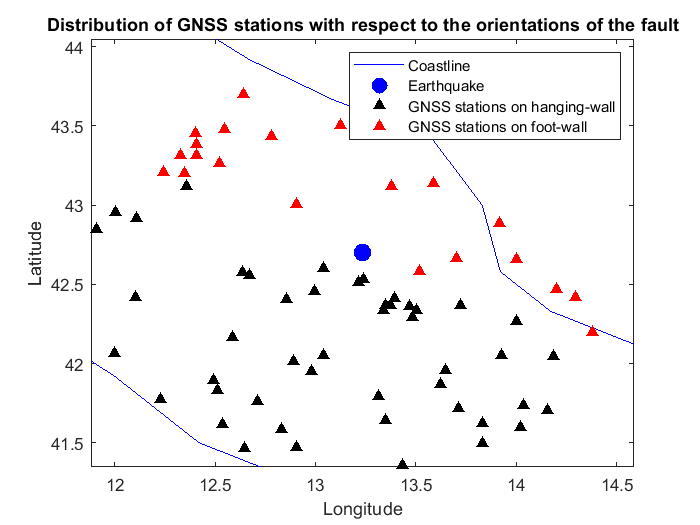

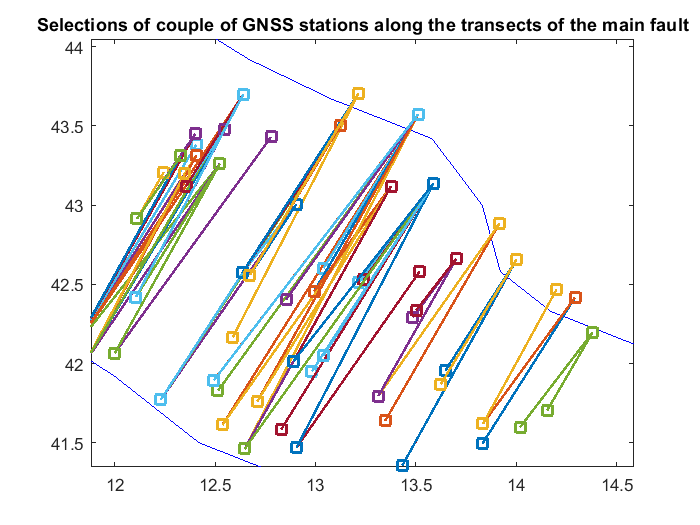

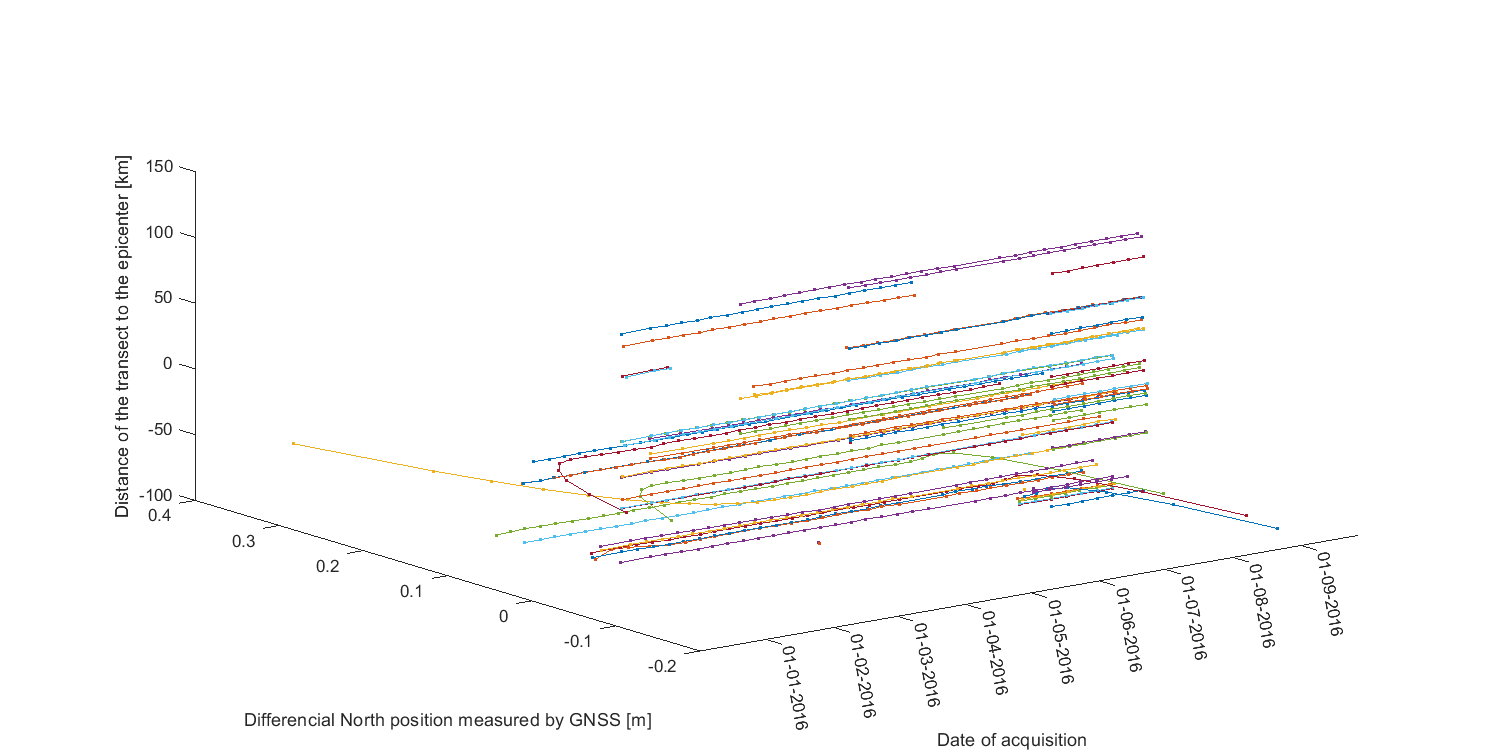

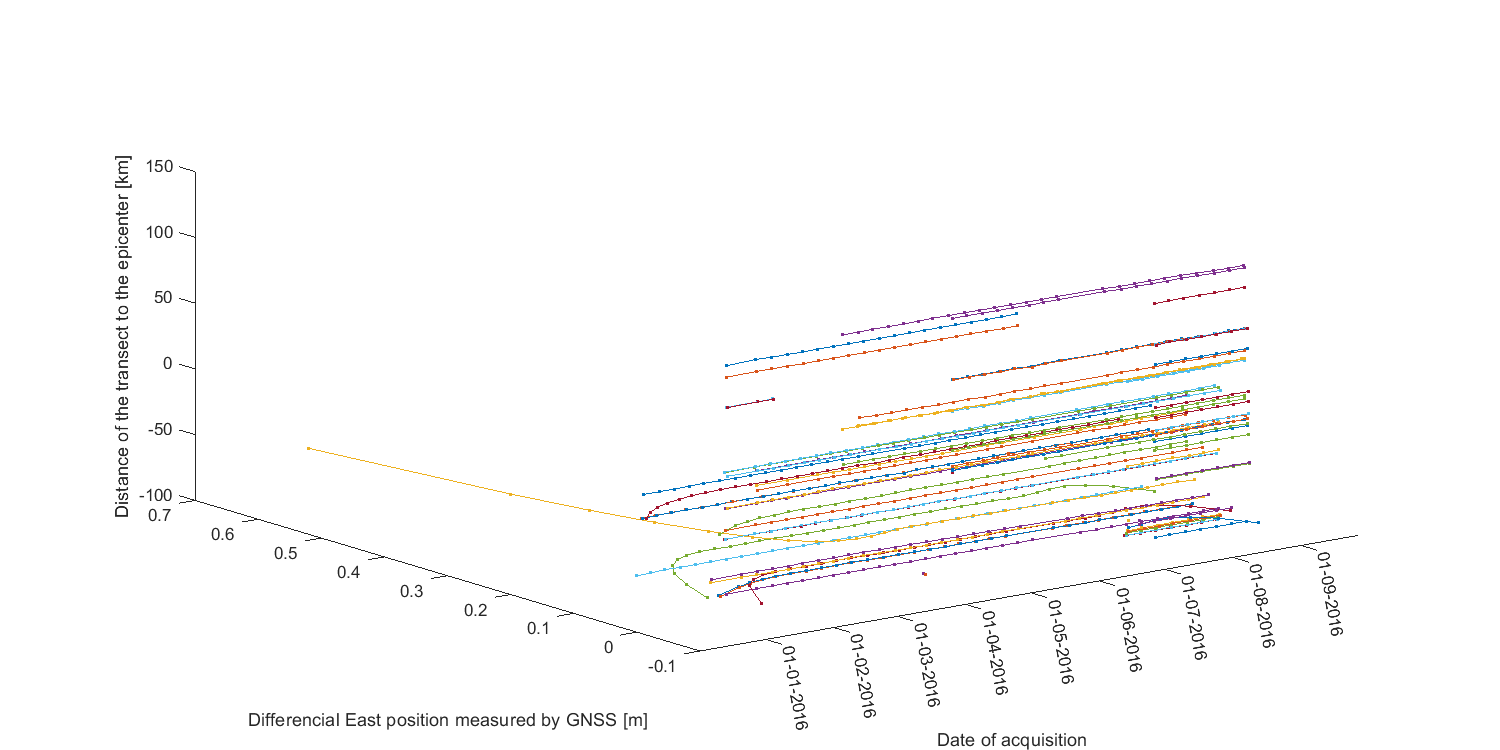

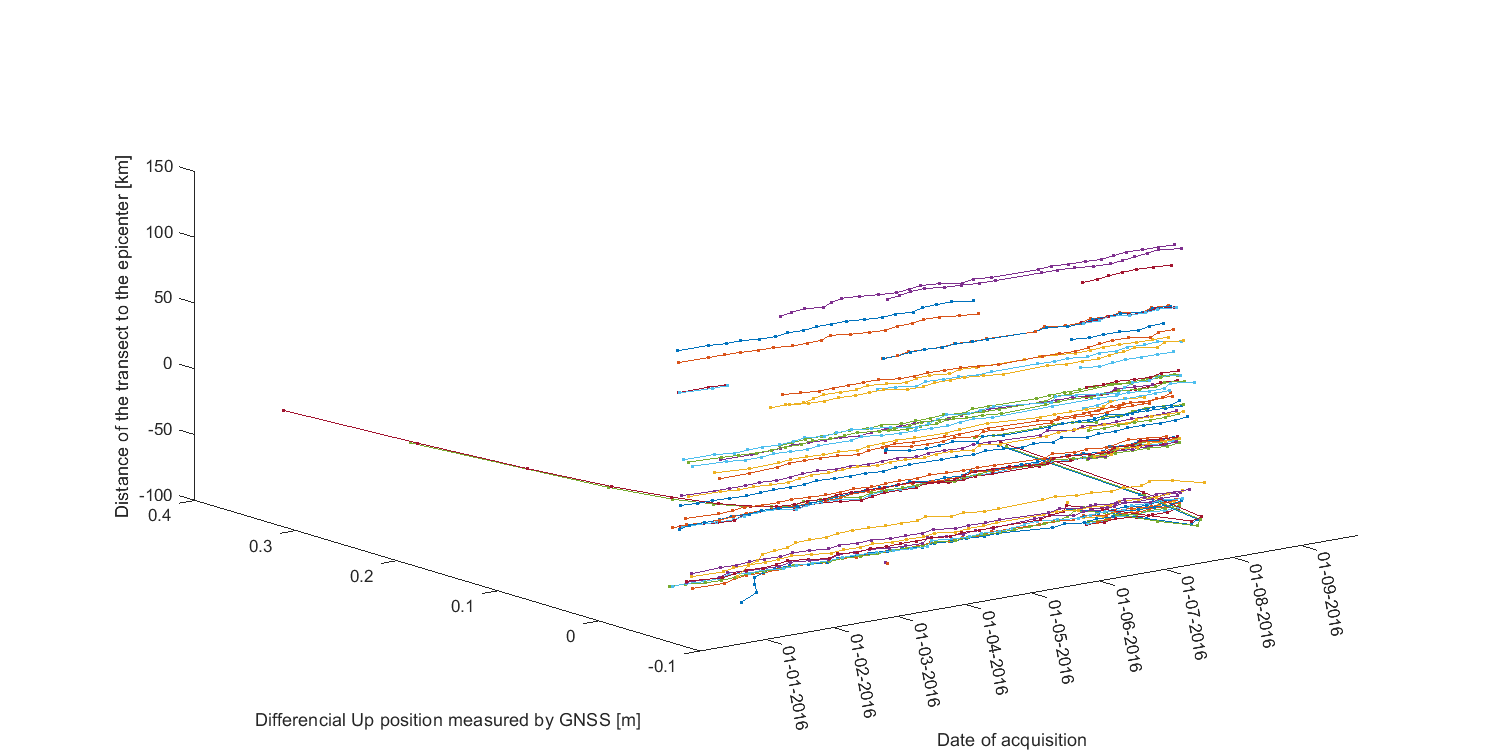

In [8]:
Complementary_strike_angle = Fault_strike - 180;
Perpendicular_angle = Fault_strike - 90;
GNSS_stations_on_footwall = data_from_GNSS((angle_to_EQ > Complementary_strike_angle & angle_to_EQ < Fault_strike) & distance_GNSS_station_EQ <= Maximum_distance);
GNSS_stations_on_hanging = data_from_GNSS((angle_to_EQ < Complementary_strike_angle | angle_to_EQ > Fault_strike) & distance_GNSS_station_EQ <= Maximum_distance);
for i = 1:size(GNSS_stations_on_hanging, 1)
    GNSS_stations_on_hanging_coordinates(i,:) = GNSS_stations_on_hanging{i}.coordinates;
end
for i = 1:size(GNSS_stations_on_footwall, 1)
    GNSS_stations_on_footwall_coordinates(i,:) = GNSS_stations_on_footwall{i}.coordinates;
end
figure
load coastlines
plot(coastlon, coastlat, '-b')
hold on
plot(epilon, epilat, 'ob', 'MarkerSize', 10, 'MarkerFaceColor', 'b')
plot(GNSS_stations_on_hanging_coordinates(:,1), GNSS_stations_on_hanging_coordinates(:,2), '^k', 'MarkerFaceColor', 'k');
plot(GNSS_stations_on_footwall_coordinates(:,1), GNSS_stations_on_footwall_coordinates(:,2), '^r', 'MarkerFaceColor', 'r');
axis([epilon-Maximum_distance/111 epilon+Maximum_distance/111 epilat-Maximum_distance/111 epilat+Maximum_distance/111]); 
xlabel('Longitude')
ylabel('Latitude')
legend('Coastline', 'Earthquake', 'GNSS stations on hanging-wall', 'GNSS stations on foot-wall');
title('Distribution of GNSS stations with respect to the orientations of the fault');


figure_2_handle = figure;
load coastlines
plot(coastlon, coastlat, '-b');
hold on;
axis([epilon-Maximum_distance/111 epilon+Maximum_distance/111 epilat-Maximum_distance/111 epilat+Maximum_distance/111]); 
title('Selections of couple of GNSS stations along the transects of the main fault');

results_from_perpendicular_stations = {};
k_stations = 1;
for i = 1:size(GNSS_stations_on_hanging, 1)
    angle_to_station = atan2d(GNSS_stations_on_footwall_coordinates(:,2)-GNSS_stations_on_hanging_coordinates(i,2),GNSS_stations_on_footwall_coordinates(:,1)-GNSS_stations_on_hanging_coordinates(i,1));
    index_good_stations_footwall = find(abs(angle_to_station - (Fault_strike-90))  <= angular_tollerance | abs(angle_to_station - (Fault_strike - 270)) <= angular_tollerance);
    if size(index_good_stations_footwall, 1) > 0
        data_from_station_1 = GNSS_stations_on_hanging{i}.data;
        for k=1:size(index_good_stations_footwall, 1) 
            data_from_station_2 = GNSS_stations_on_footwall{index_good_stations_footwall(k)}.data;
            data_from_station_2_resamples = nan(size(data_from_station_1,1), 4);
            data_from_station_2_resamples(:,1) = data_from_station_1(:,1);
            data_from_station_2_resamples(:,2) = interp1(data_from_station_2(:,1),data_from_station_2(:,2), data_from_station_2_resamples(:,1), 'pchip', 'extrap');
            data_from_station_2_resamples(:,3) = interp1(data_from_station_2(:,1),data_from_station_2(:,3), data_from_station_2_resamples(:,1), 'pchip', 'extrap');
            data_from_station_2_resamples(:,4) = interp1(data_from_station_2(:,1),data_from_station_2(:,4), data_from_station_2_resamples(:,1), 'pchip', 'extrap');
            differences_GNSS = (data_from_station_1(:,2:4) - data_from_station_2_resamples(:,2:4));
            distance_st1_st2 = distance(GNSS_stations_on_footwall{index_good_stations_footwall(k)}.coordinates(2), GNSS_stations_on_footwall{index_good_stations_footwall(k)}.coordinates(1), ...
                GNSS_stations_on_hanging{i}.coordinates(2), GNSS_stations_on_hanging{i}.coordinates(1));
            distance_st1_EQ = distance(epilat, epilon, GNSS_stations_on_hanging{i}.coordinates(2), GNSS_stations_on_hanging{i}.coordinates(1));
            distance_EQ_st2 = distance(GNSS_stations_on_footwall{index_good_stations_footwall(k)}.coordinates(2), GNSS_stations_on_footwall{index_good_stations_footwall(k)}.coordinates(1), epilat, epilon); 
            semiperimeter = 0.5 * (distance_st1_st2+distance_st1_EQ+distance_EQ_st2);
            area = sqrt(semiperimeter*(semiperimeter-distance_st1_st2)*(semiperimeter-distance_st1_EQ)*(semiperimeter-distance_EQ_st2));
            height_triangle = 2 * area / distance_st1_st2;
            distance_st1_st2_from_EQ = height_triangle * 111;
            angle_of_st2_to_EQ = atan2d(GNSS_stations_on_footwall{index_good_stations_footwall(k)}.coordinates(2)-epilat,GNSS_stations_on_footwall{index_good_stations_footwall(k)}.coordinates(1)-epilon);
            if angle_of_st2_to_EQ > Perpendicular_angle
                distance_st1_st2_from_EQ = - distance_st1_st2_from_EQ;
            end
            figure(figure_2_handle)
            plot([GNSS_stations_on_footwall{index_good_stations_footwall(k)}.coordinates(1), GNSS_stations_on_hanging{i}.coordinates(1)], [GNSS_stations_on_footwall{index_good_stations_footwall(k)}.coordinates(2), GNSS_stations_on_hanging{i}.coordinates(2)], 's-', 'LineWidth', 1.5, 'MarkerSize', 8);
            results_from_perpendicular_stations{k_stations,1}.distance = distance_st1_st2_from_EQ;
            results_from_perpendicular_stations{k_stations,1}.differences_GNSS = differences_GNSS;
            results_from_perpendicular_stations{k_stations,1}.time_differences_GNSS = data_from_station_1(:,1);
            results_from_perpendicular_stations{k_stations,1}.distance_st1_st2 = distance_st1_st2;
            k_stations = k_stations + 1;
            
        end
    end
end

distance_GNSS = nan(k_stations-1,1);
for i = 1:size(results_from_perpendicular_stations,1)
    distance_GNSS(i,1) = results_from_perpendicular_stations{i}.distance;
end


figure('Position', [1 1 1200 600])
for i = 1:size(results_from_perpendicular_stations,1)
    distance_GNSS = results_from_perpendicular_stations{i}.distance;
    data_station = results_from_perpendicular_stations{i}.differences_GNSS;
    time_data_station = results_from_perpendicular_stations{i}.time_differences_GNSS;
    plot3(time_data_station, data_station(:,1), distance_GNSS*ones(size(time_data_station, 1), 1), '.-');
    hold on;
end
datetick('x', 'dd-mm-yyyy', 'keeplimits');
xlabel('Date of acquisition')
ylabel('Differencial North position measured by GNSS [m]')
zlabel('Distance of the transect to the epicenter [km]');

figure('Position', [1 1 1200 600])
for i = 1:size(results_from_perpendicular_stations,1)
    distance_GNSS = results_from_perpendicular_stations{i}.distance;
    data_station = results_from_perpendicular_stations{i}.differences_GNSS;
    time_data_station = results_from_perpendicular_stations{i}.time_differences_GNSS;
    plot3(time_data_station, data_station(:,2), distance_GNSS*ones(size(time_data_station, 1), 1), '.-');
    hold on;
end
datetick('x', 'dd-mm-yyyy', 'keeplimits');
xlabel('Date of acquisition')
ylabel('Differencial East position measured by GNSS [m]')
zlabel('Distance of the transect to the epicenter [km]');

figure('Position', [1 1 1200 600])
for i = 1:size(results_from_perpendicular_stations,1)
    distance_GNSS = results_from_perpendicular_stations{i}.distance;
    data_station = results_from_perpendicular_stations{i}.differences_GNSS;
    time_data_station = results_from_perpendicular_stations{i}.time_differences_GNSS;
    plot3(time_data_station, data_station(:,3), distance_GNSS*ones(size(time_data_station, 1), 1), '.-');
    hold on;
end
datetick('x', 'dd-mm-yyyy', 'keeplimits');
xlabel('Date of acquisition')
ylabel('Differencial Up position measured by GNSS [m]')
zlabel('Distance of the transect to the epicenter [km]');

## Creations of maps of GNSS rate of displacements

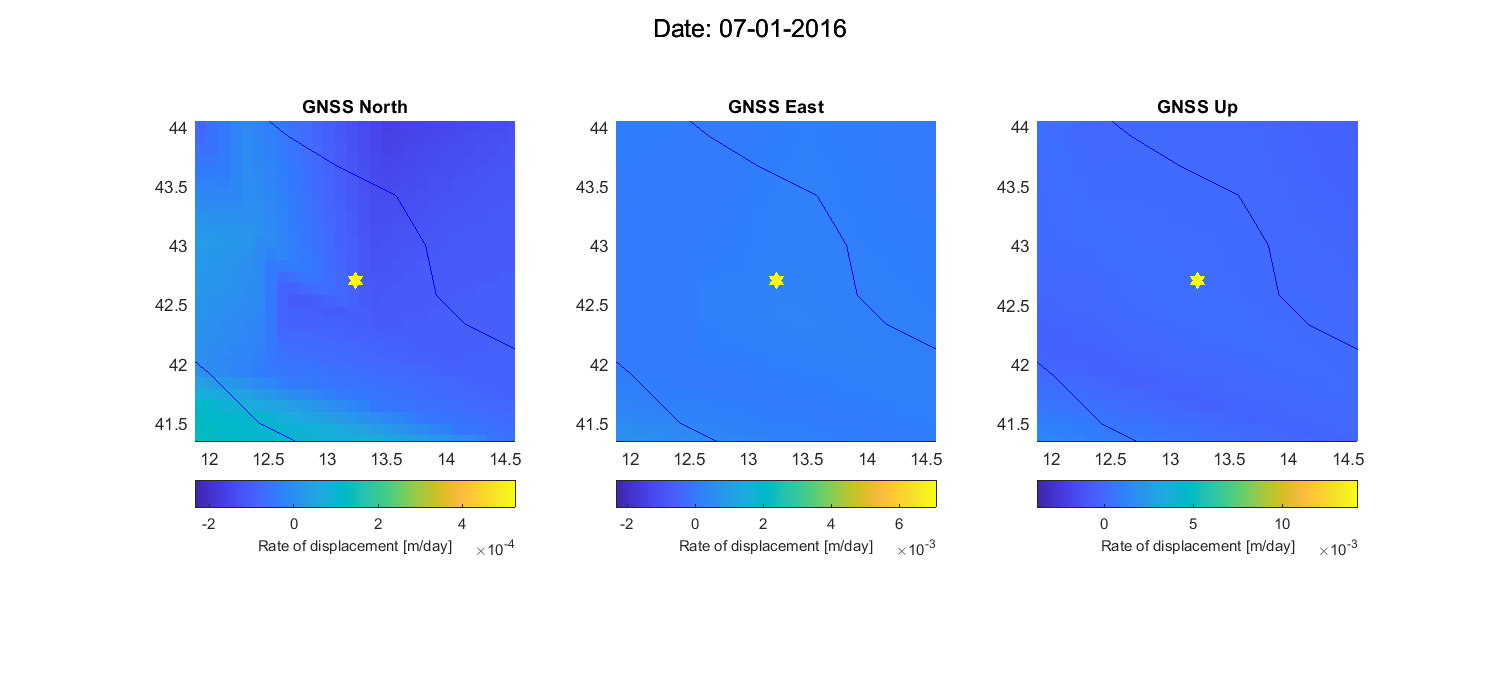

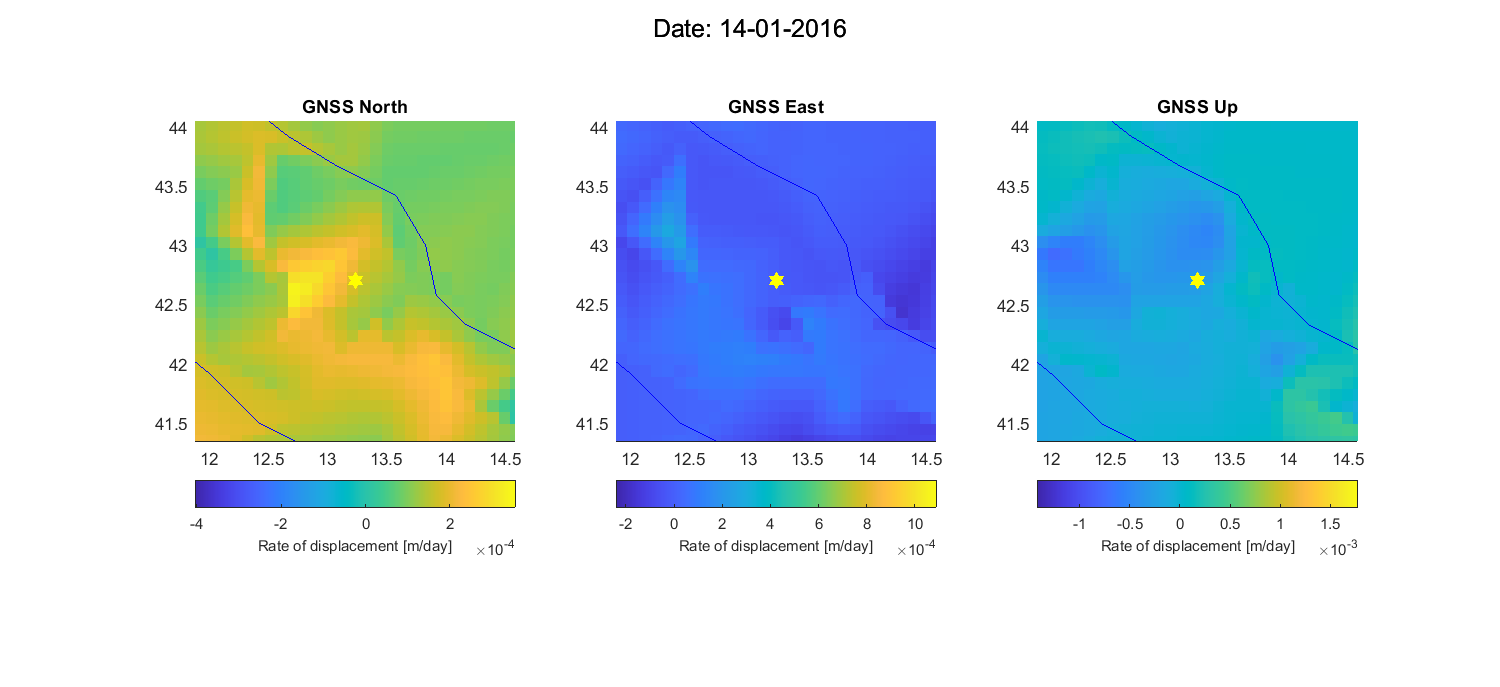

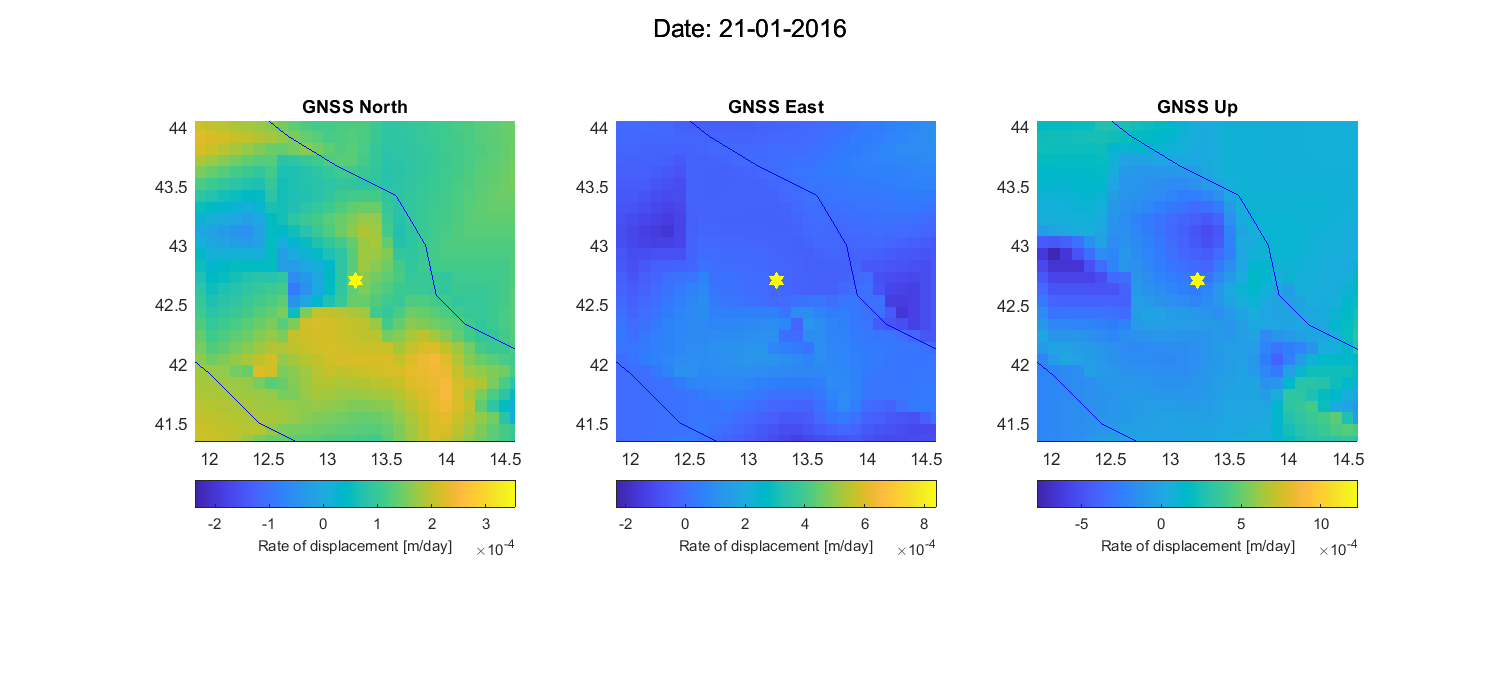

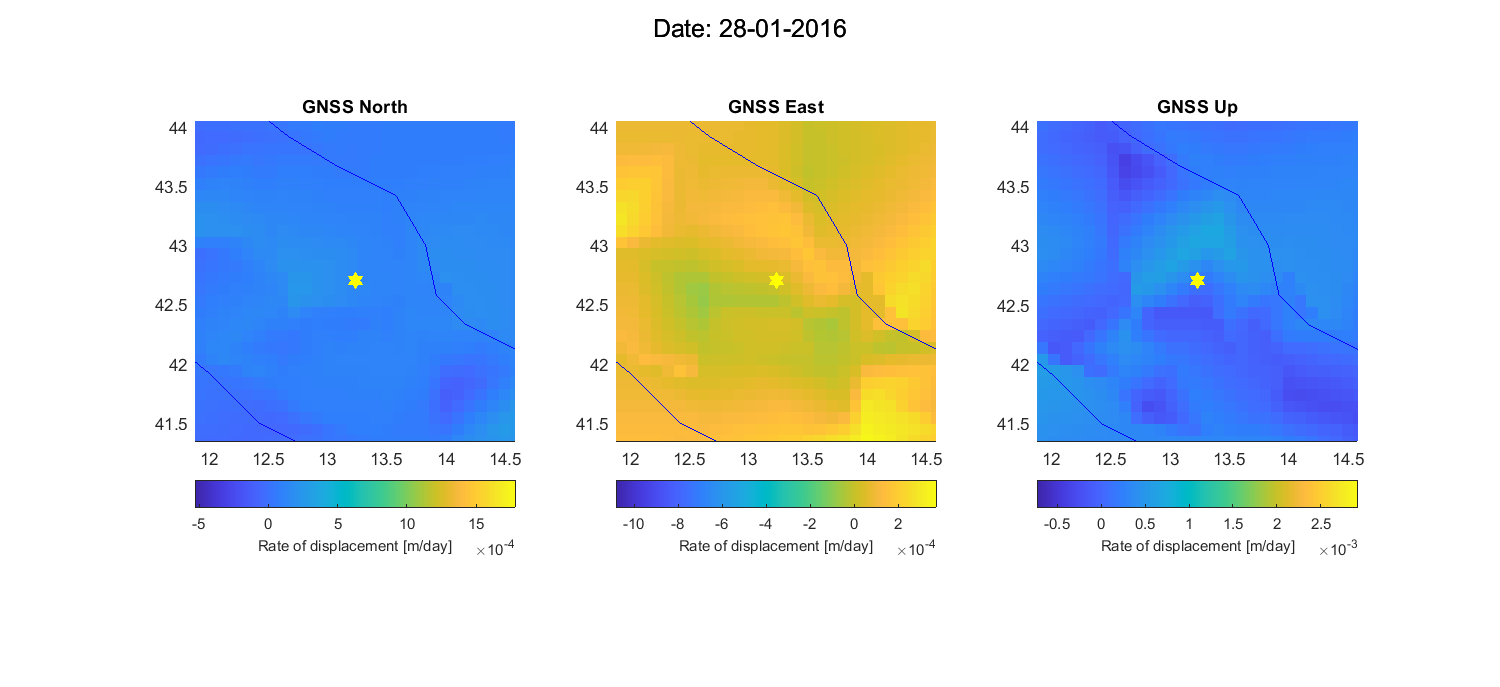

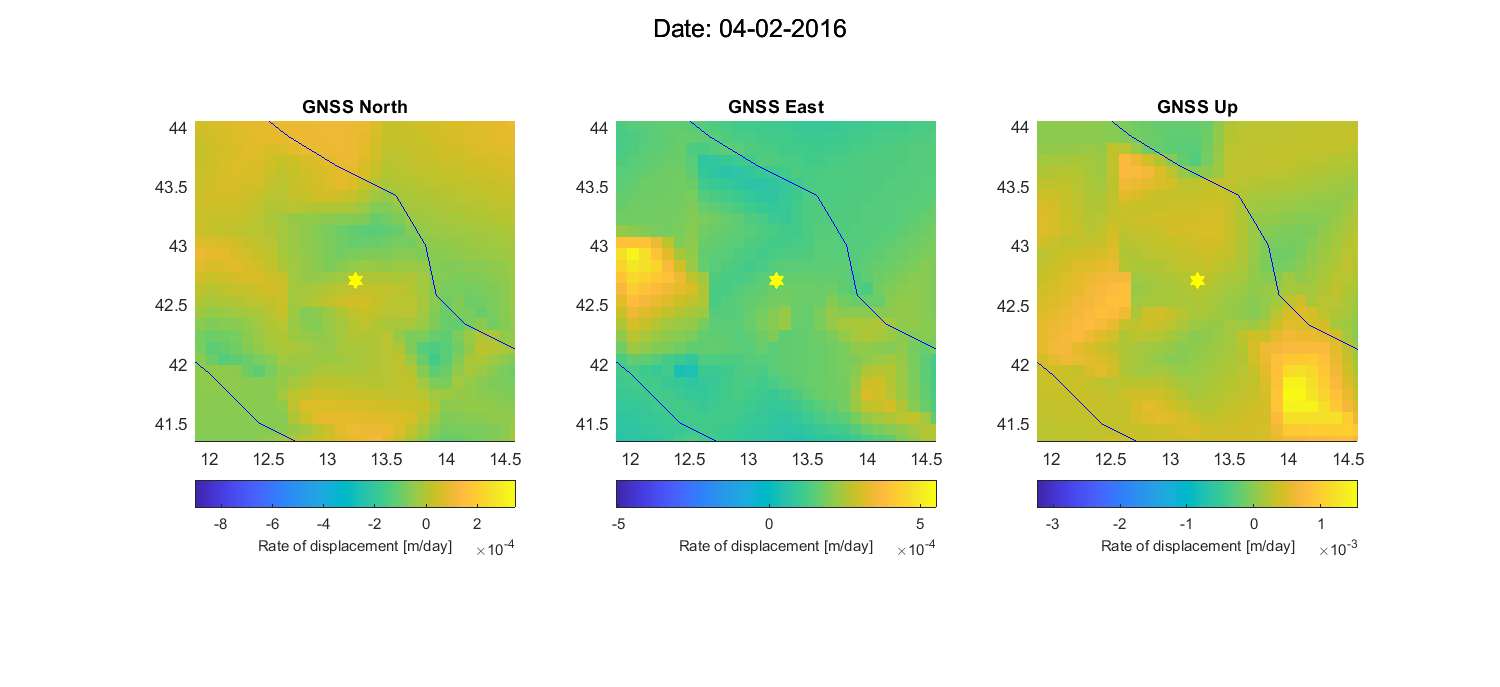

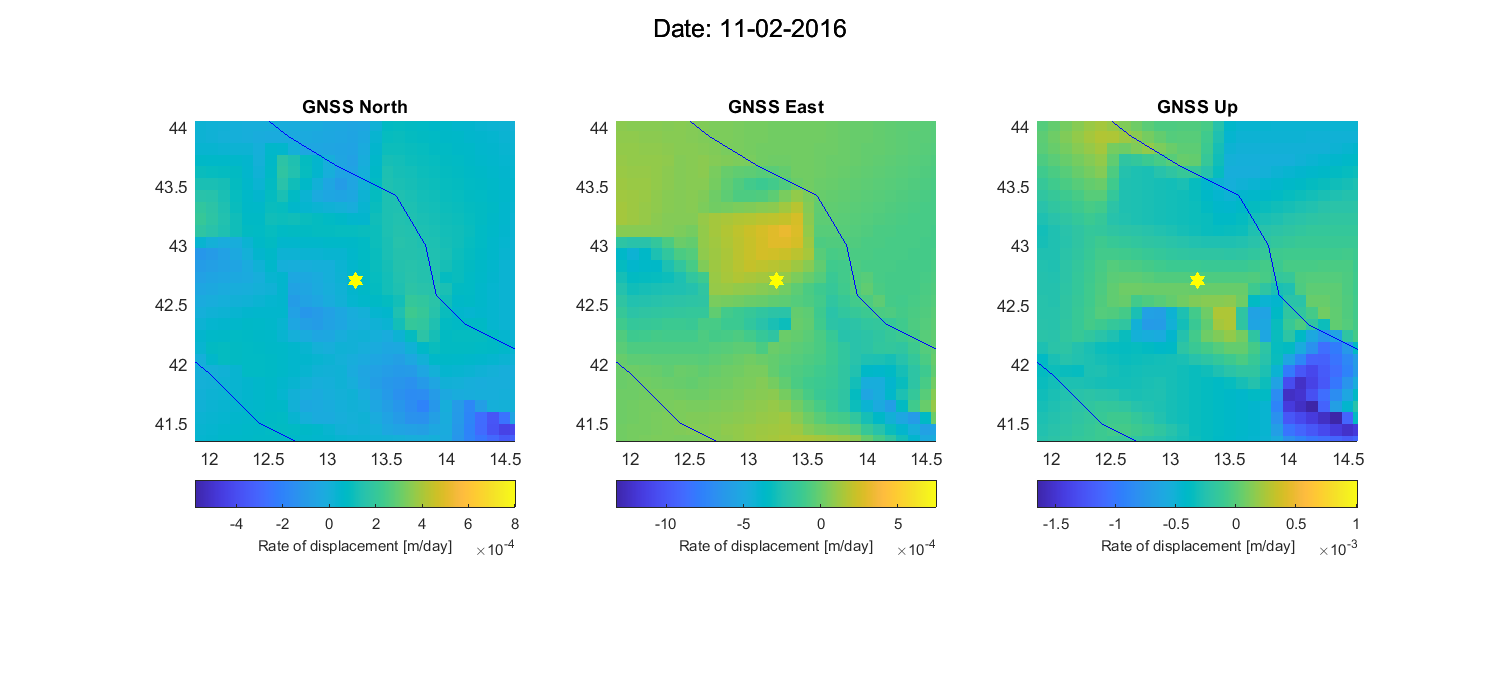

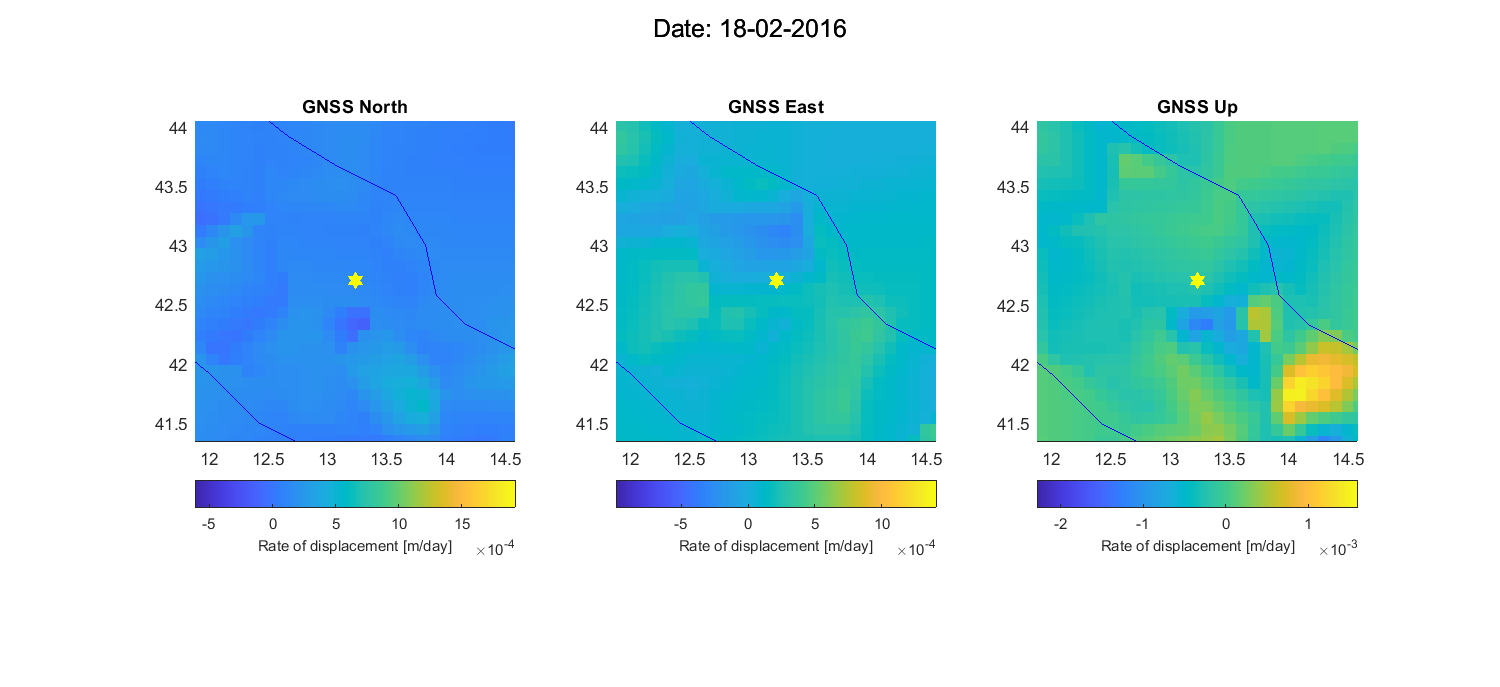

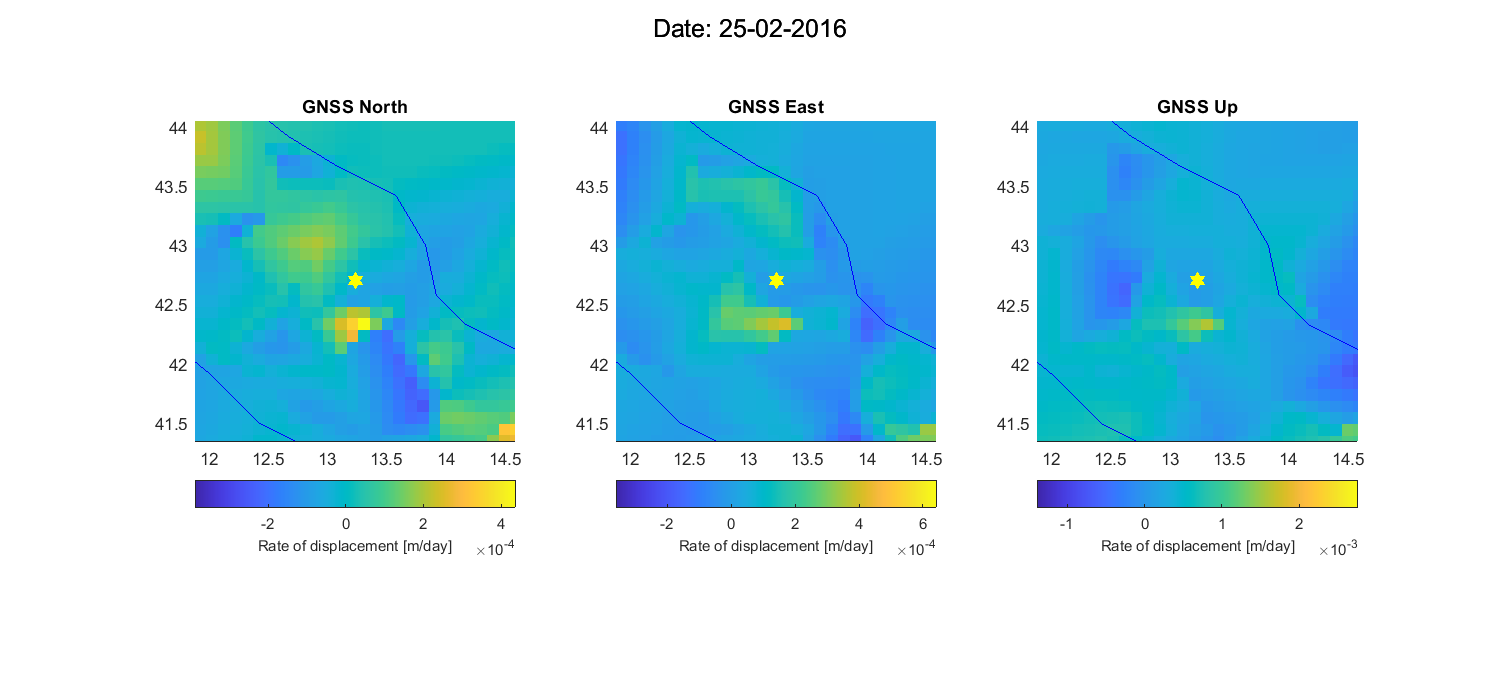

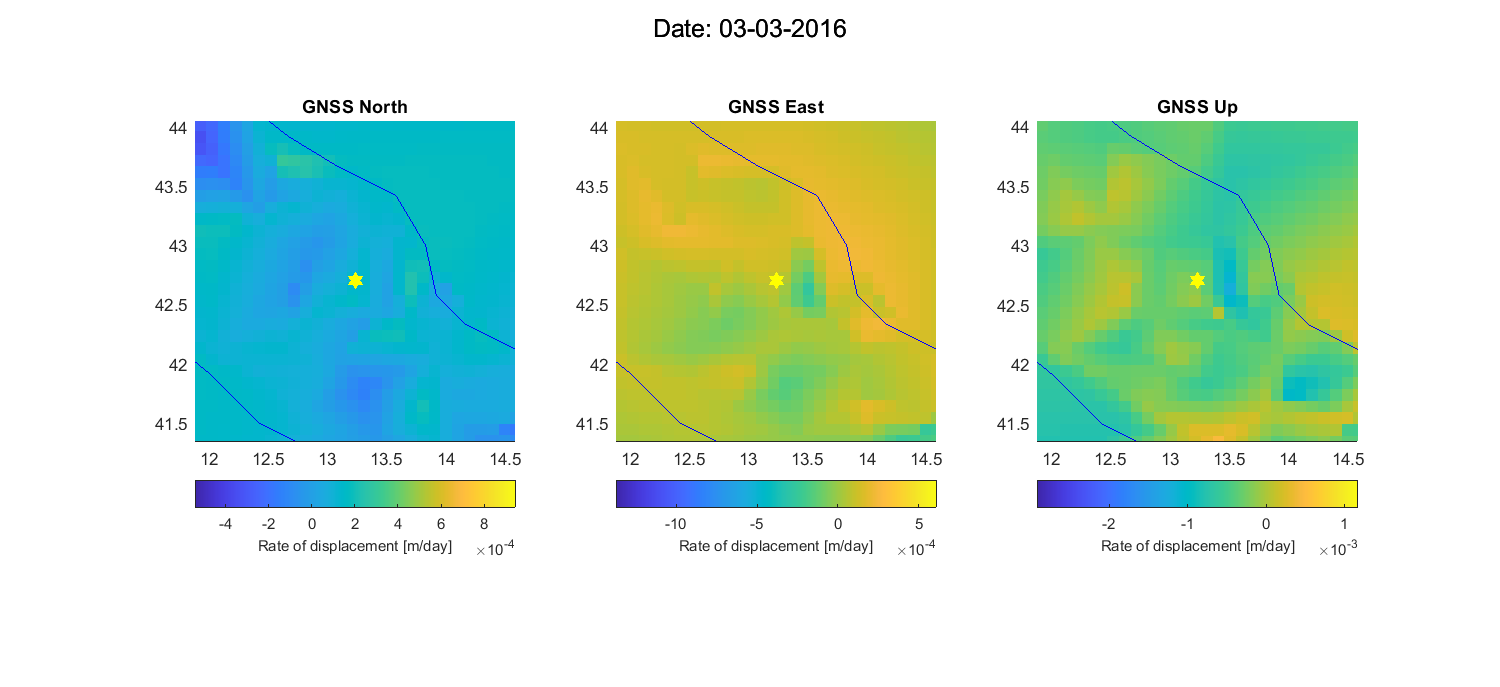

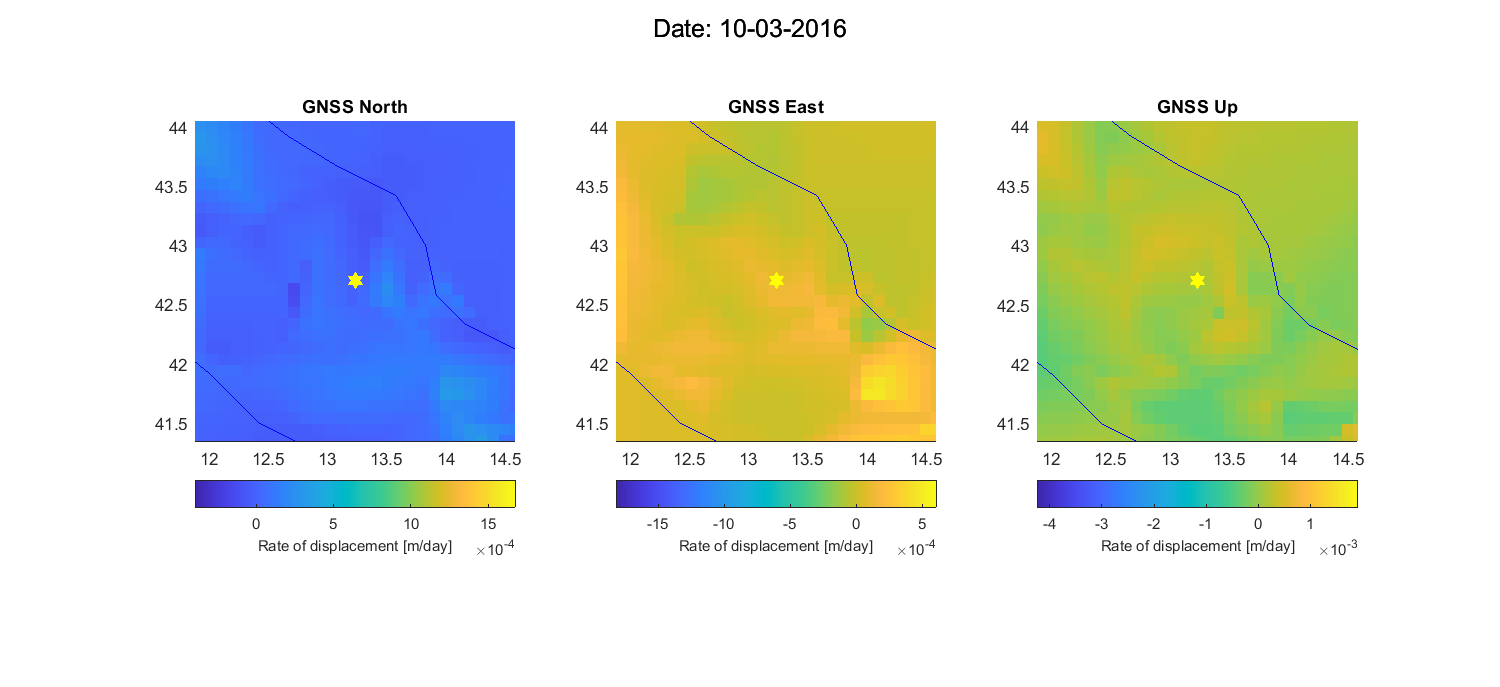

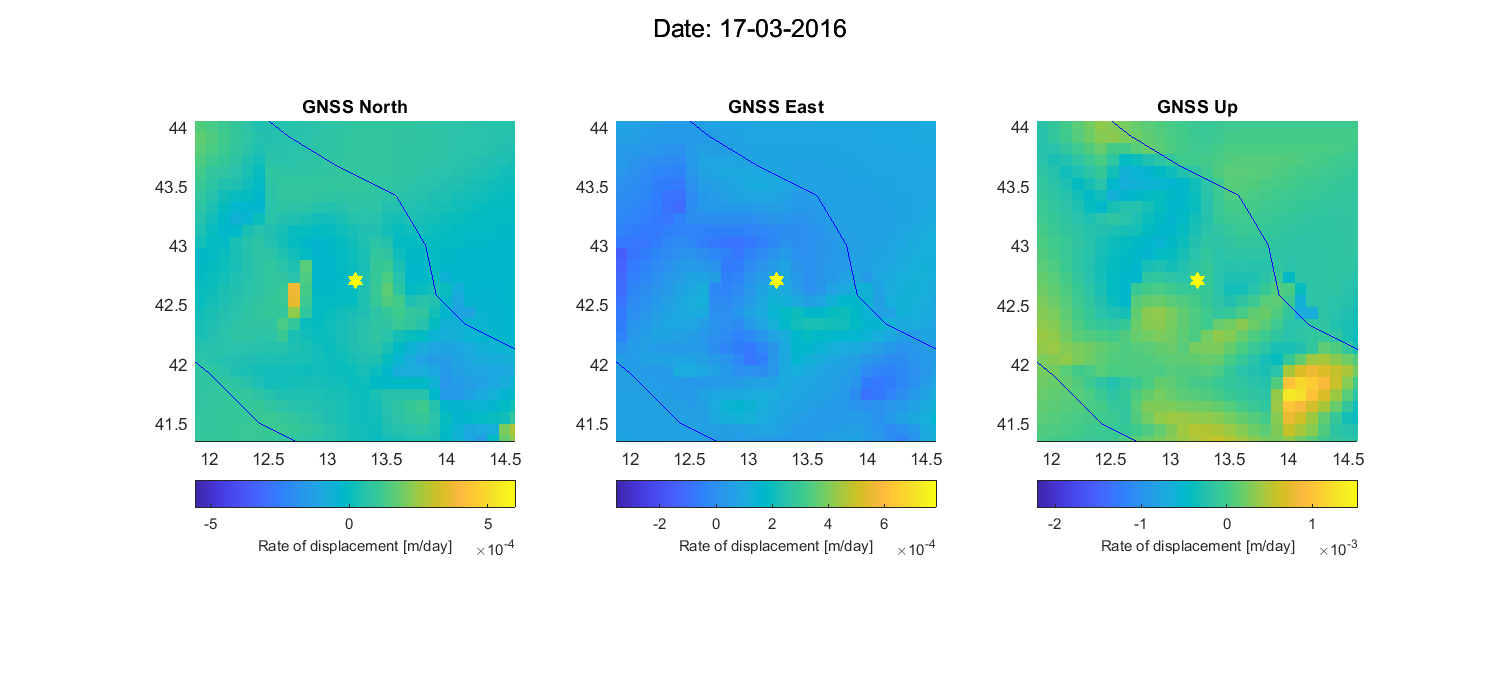

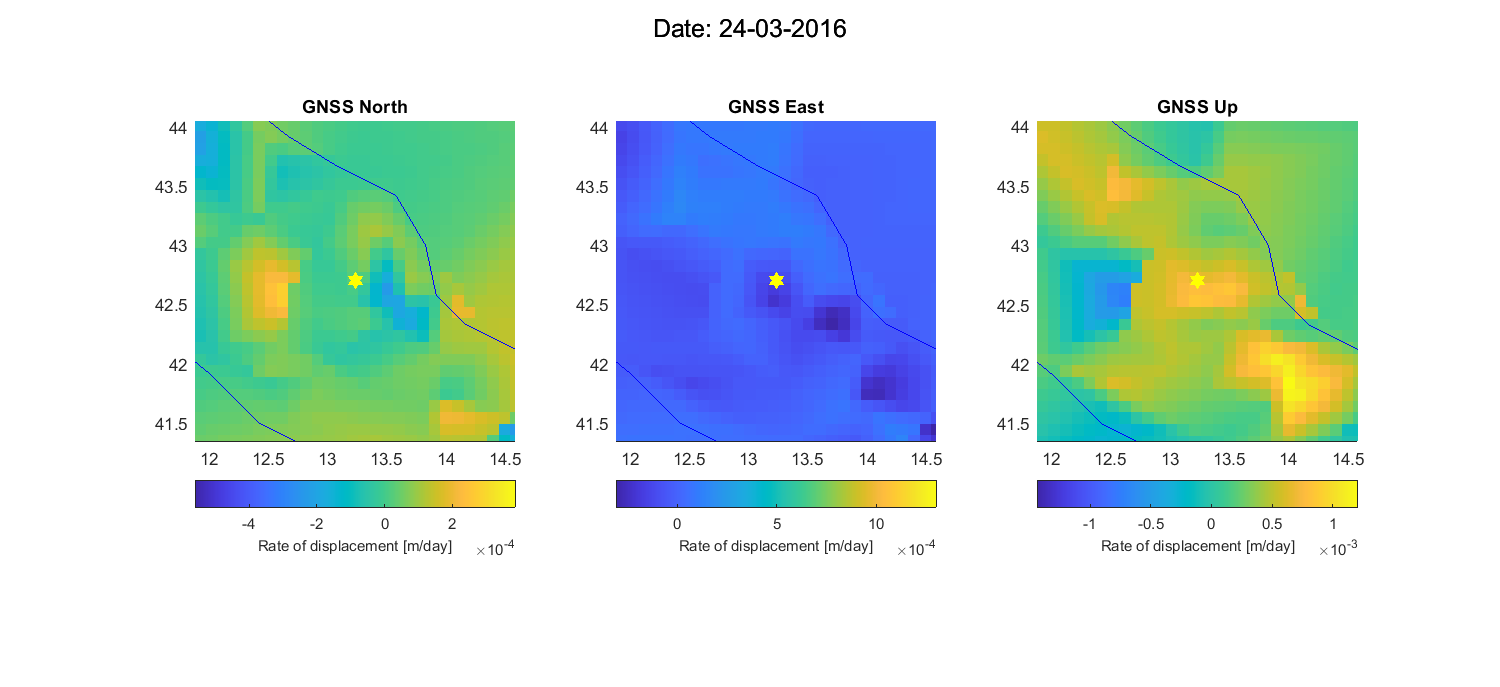

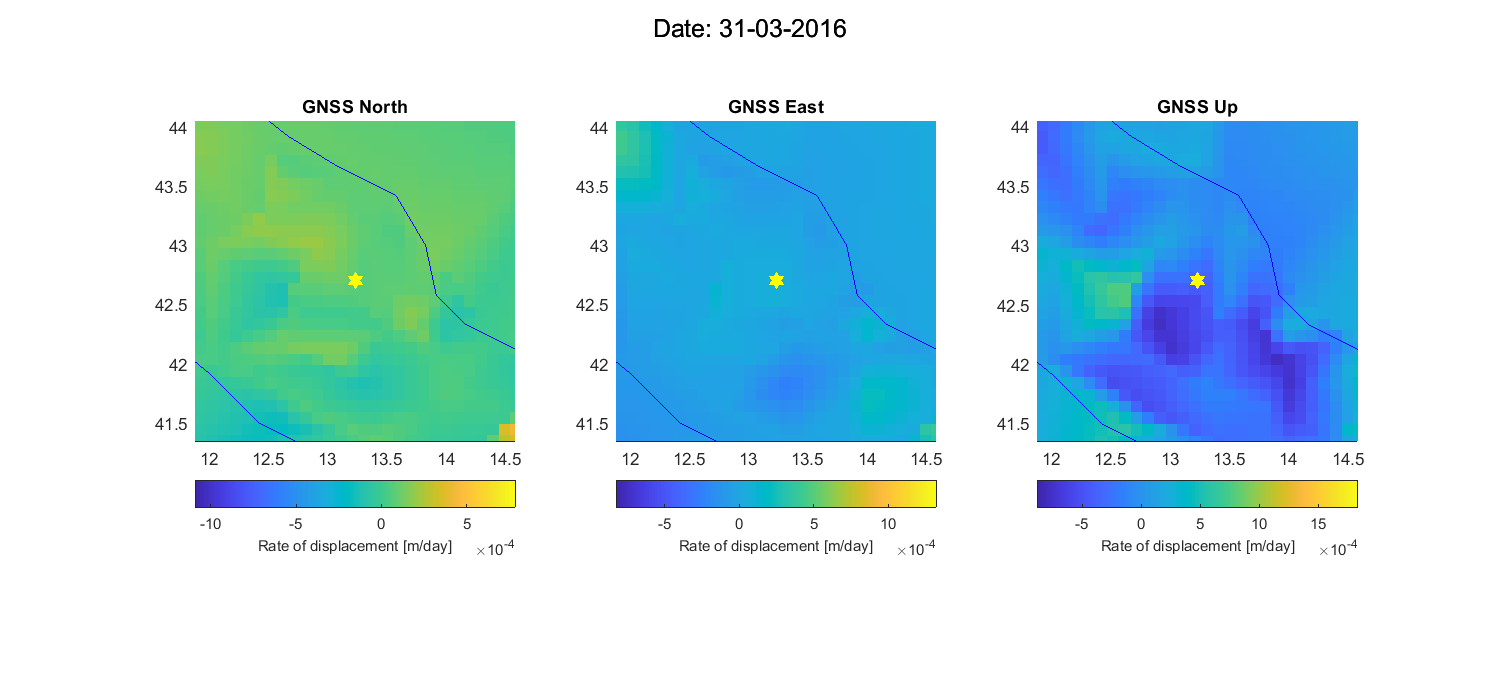

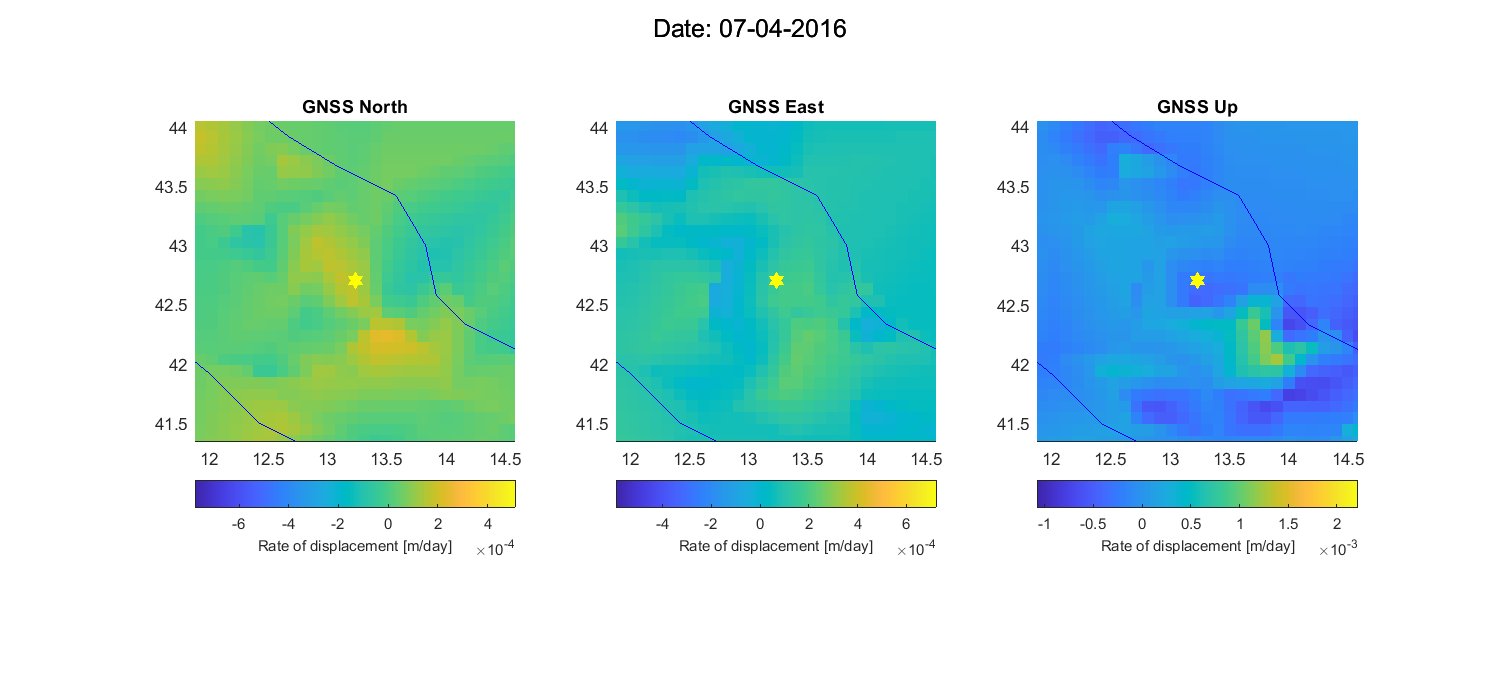

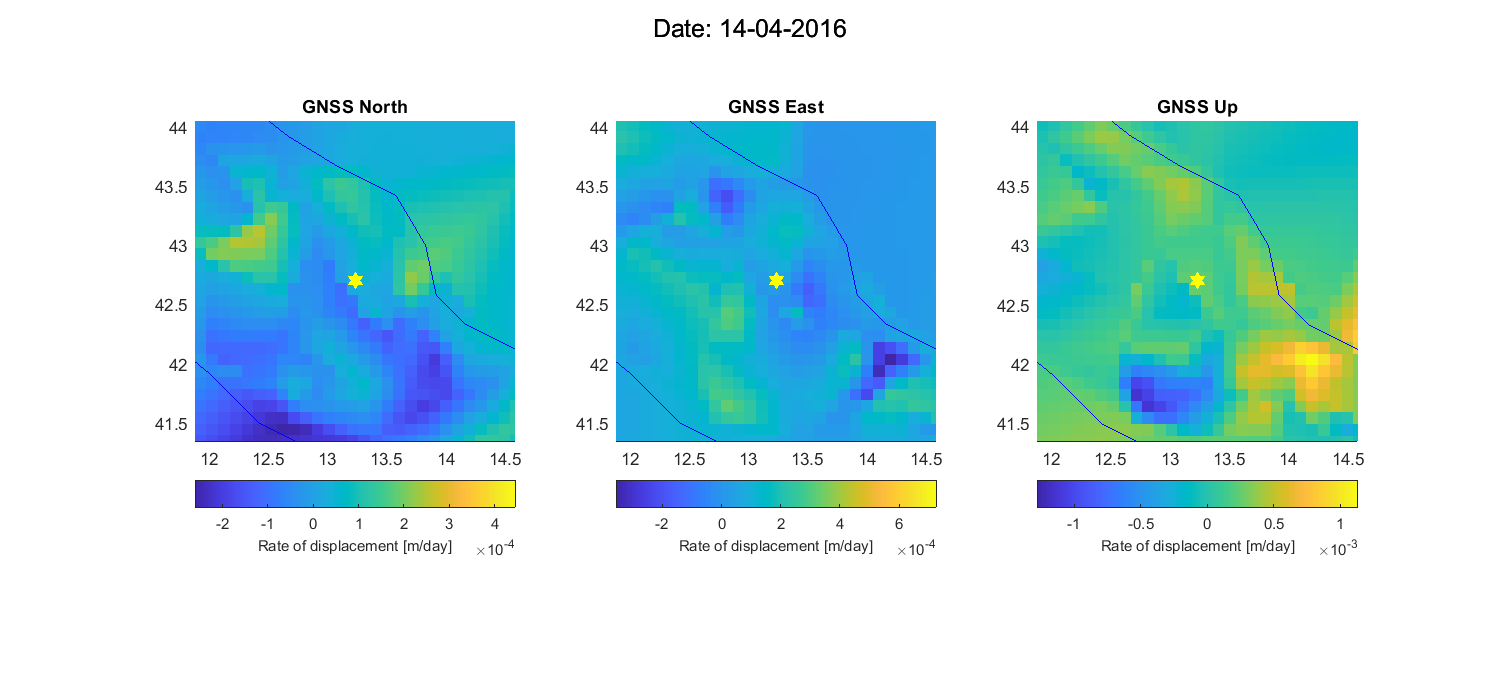

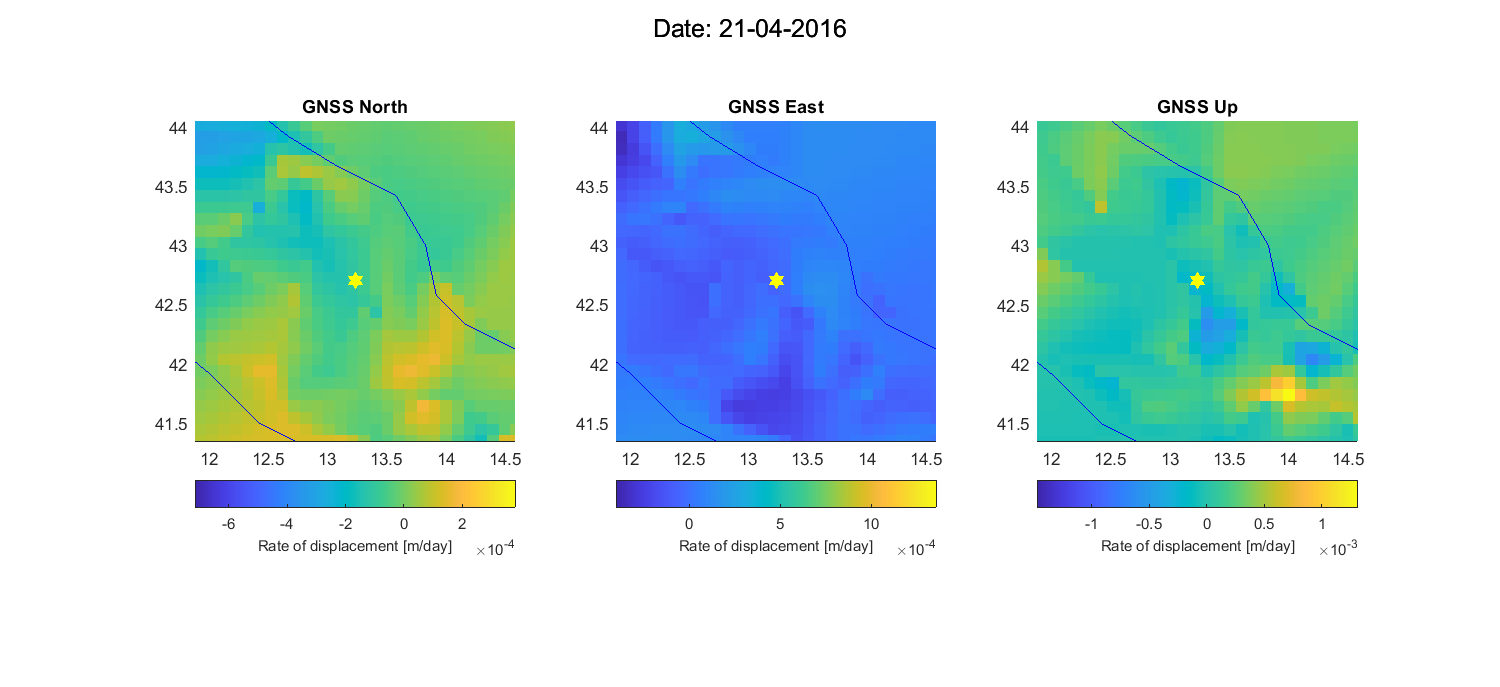

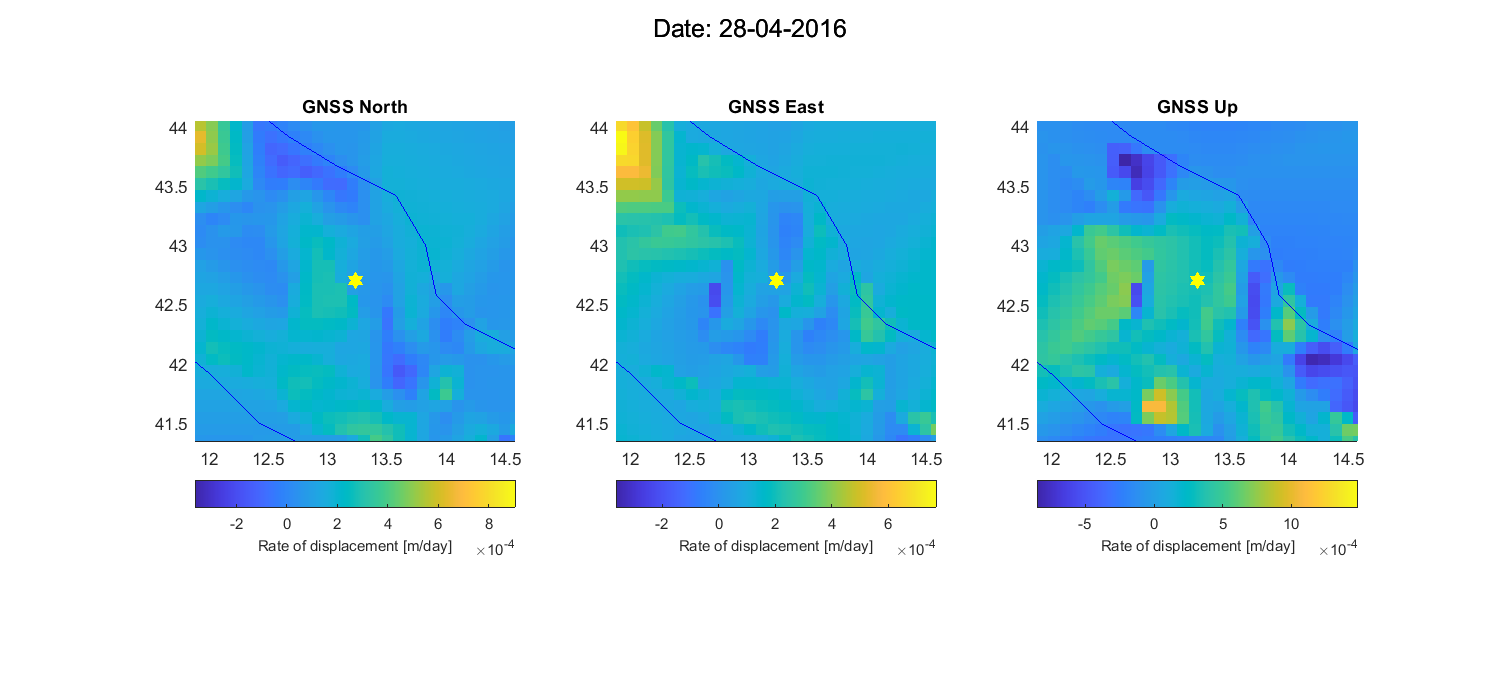

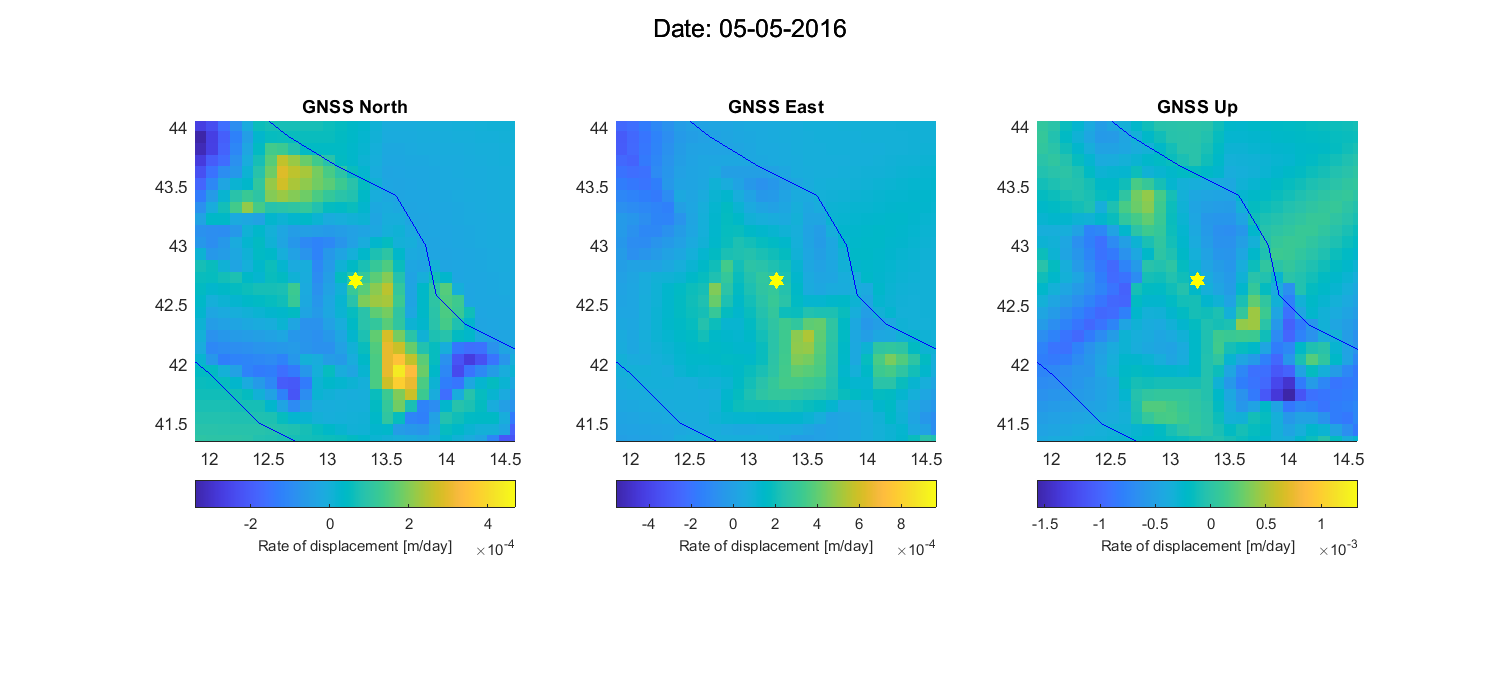

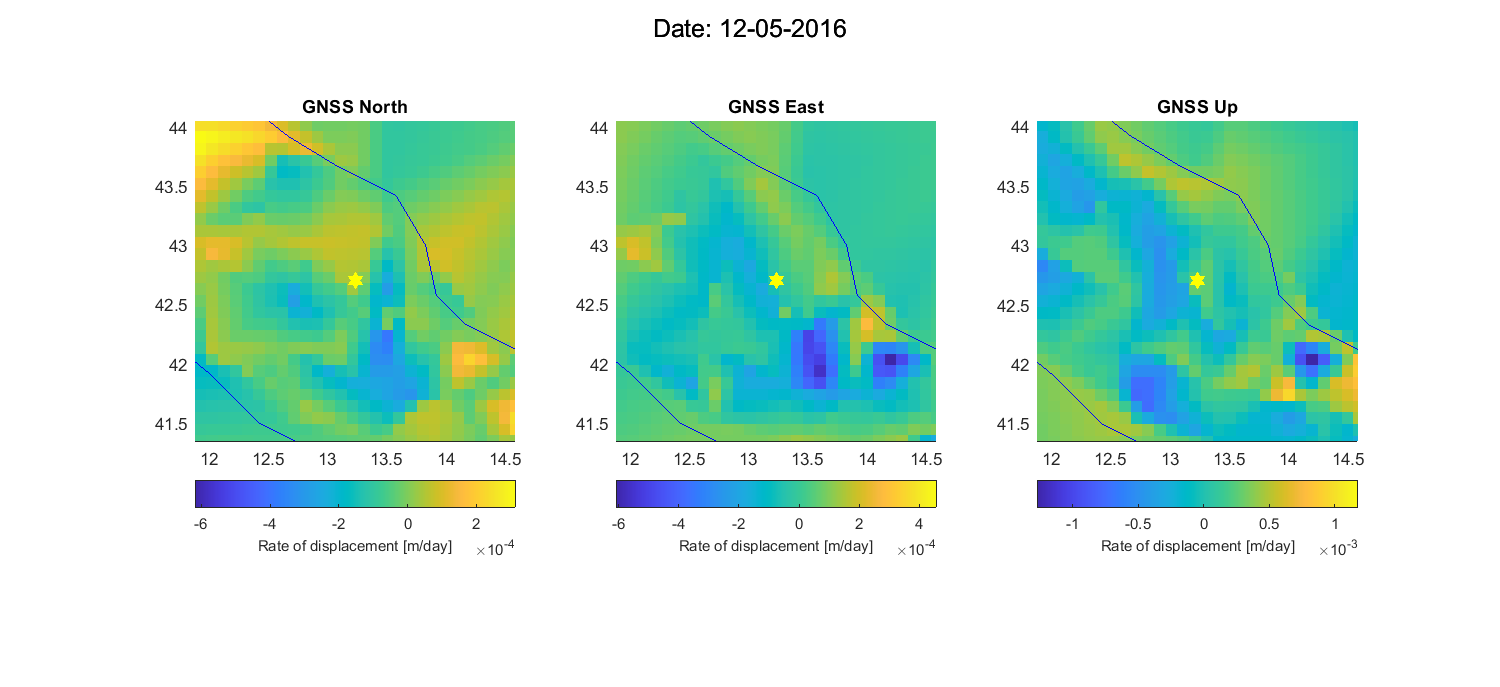

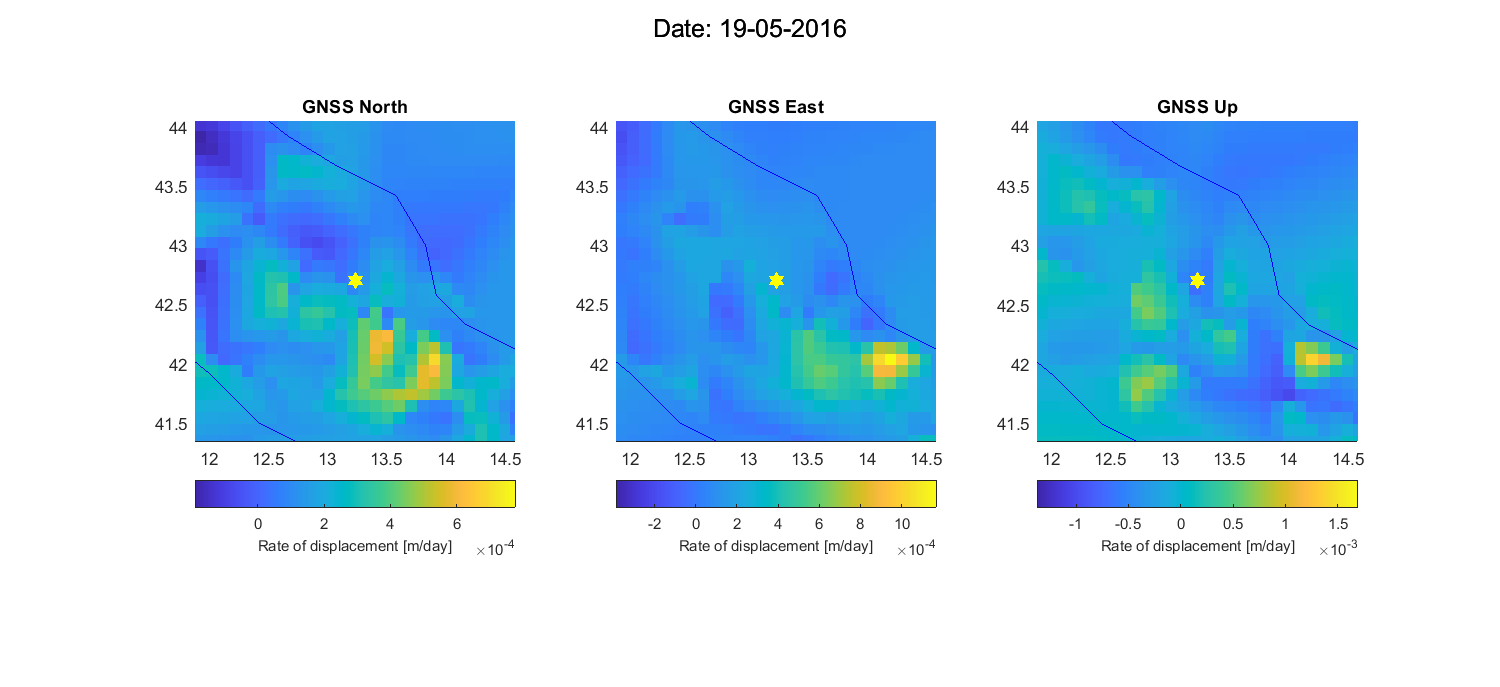

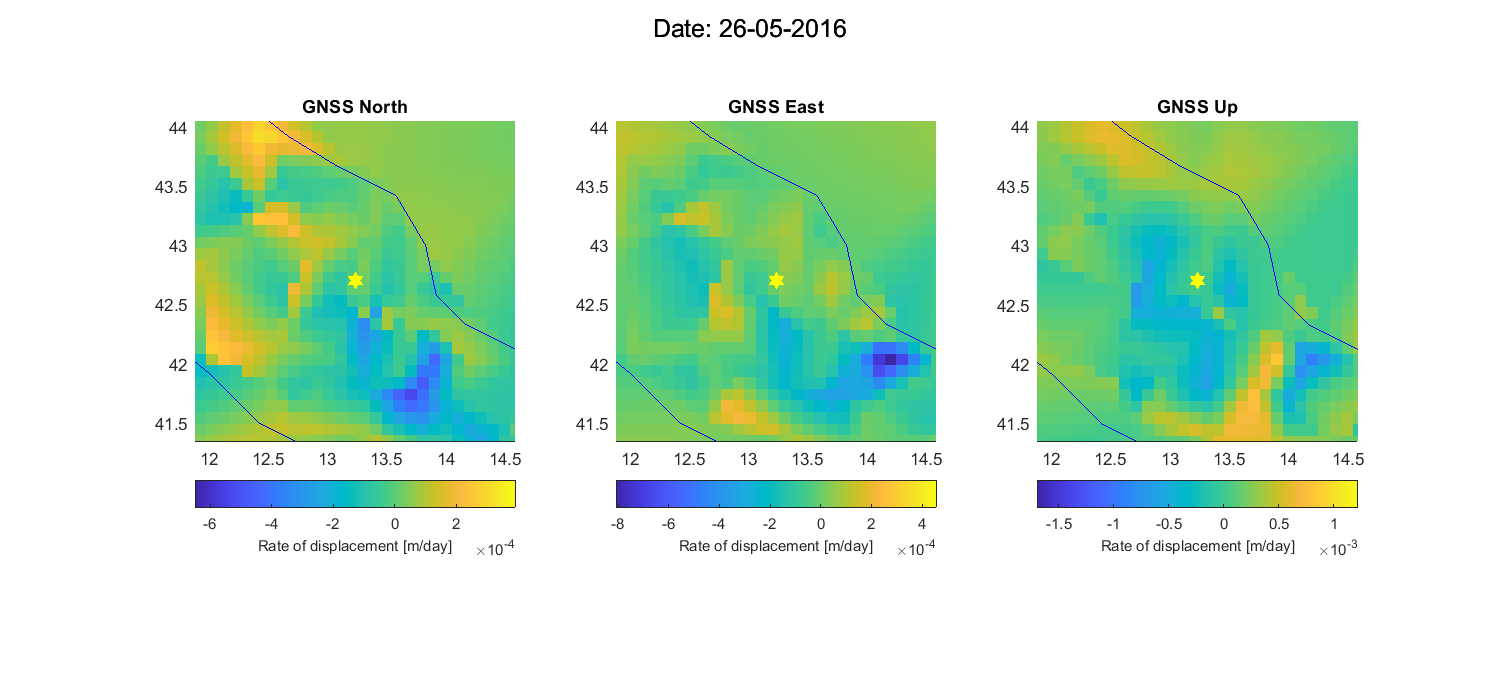

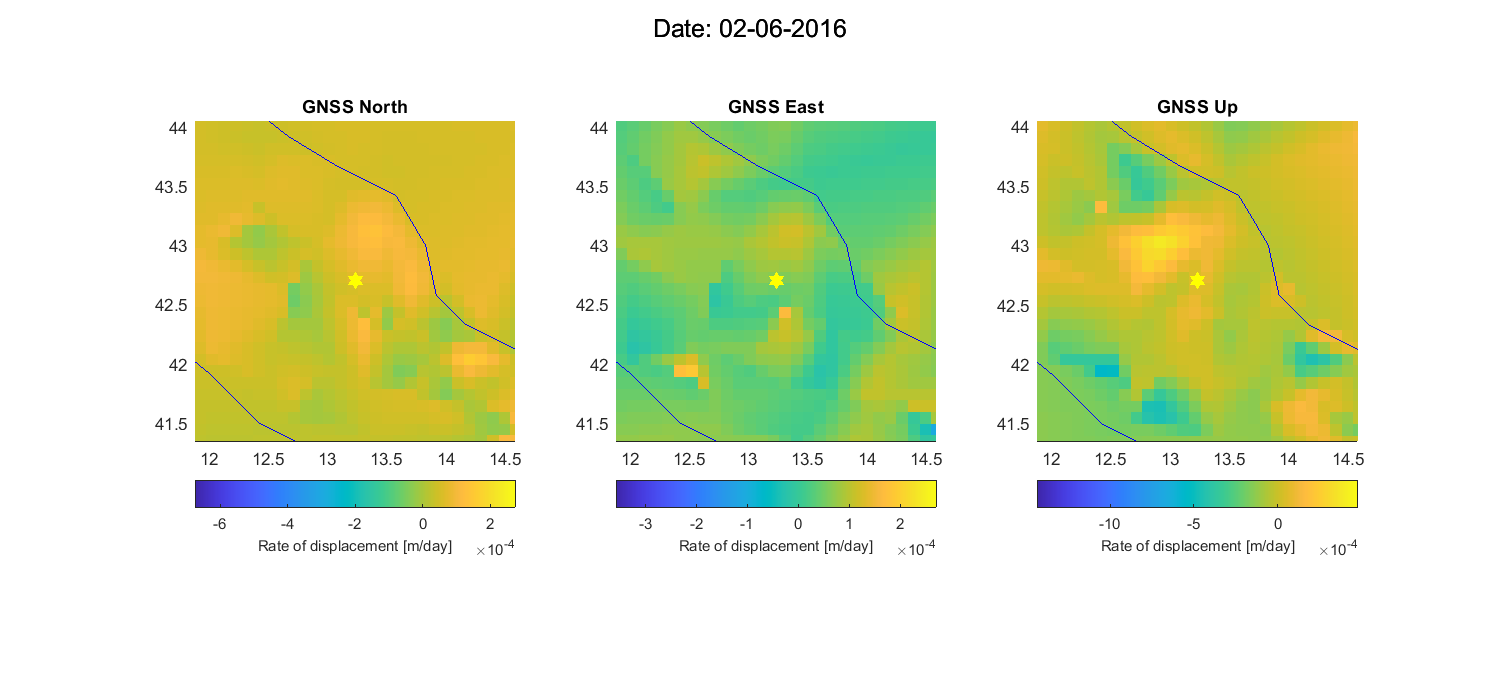

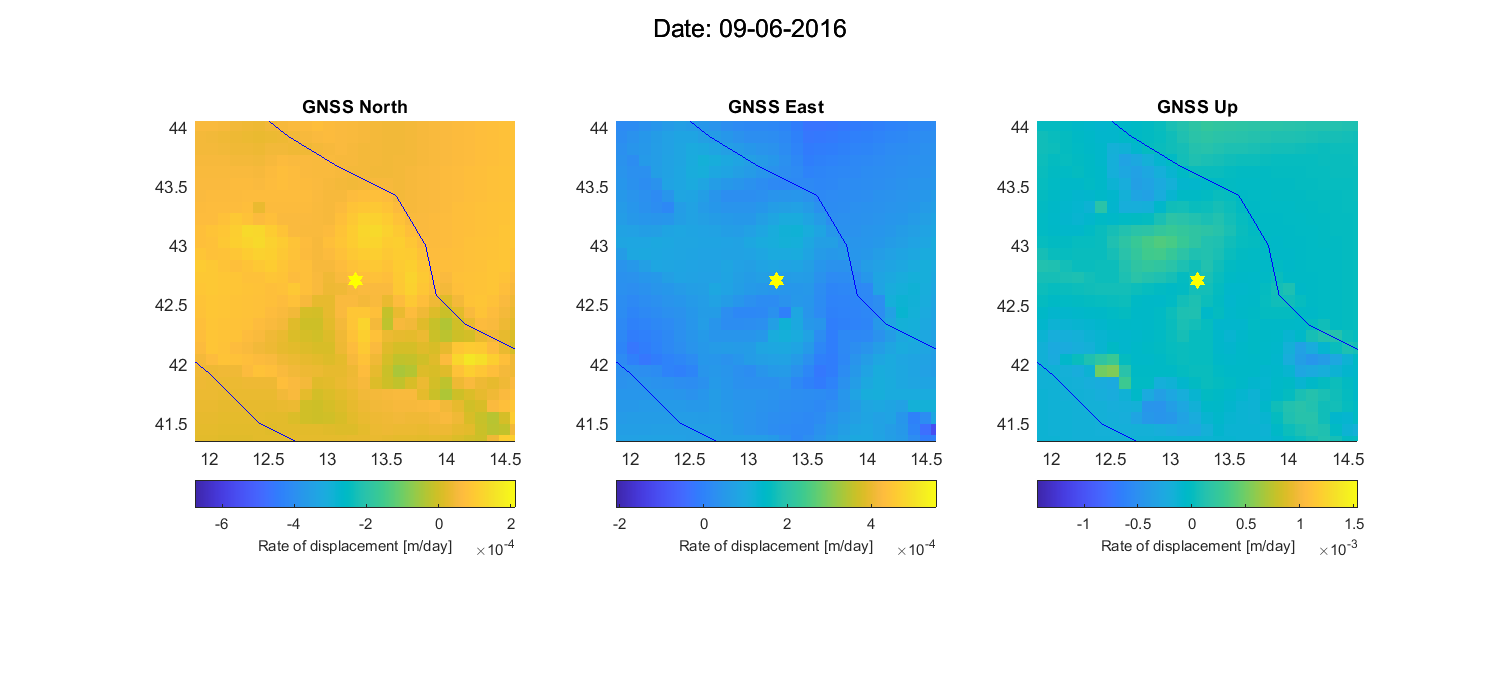

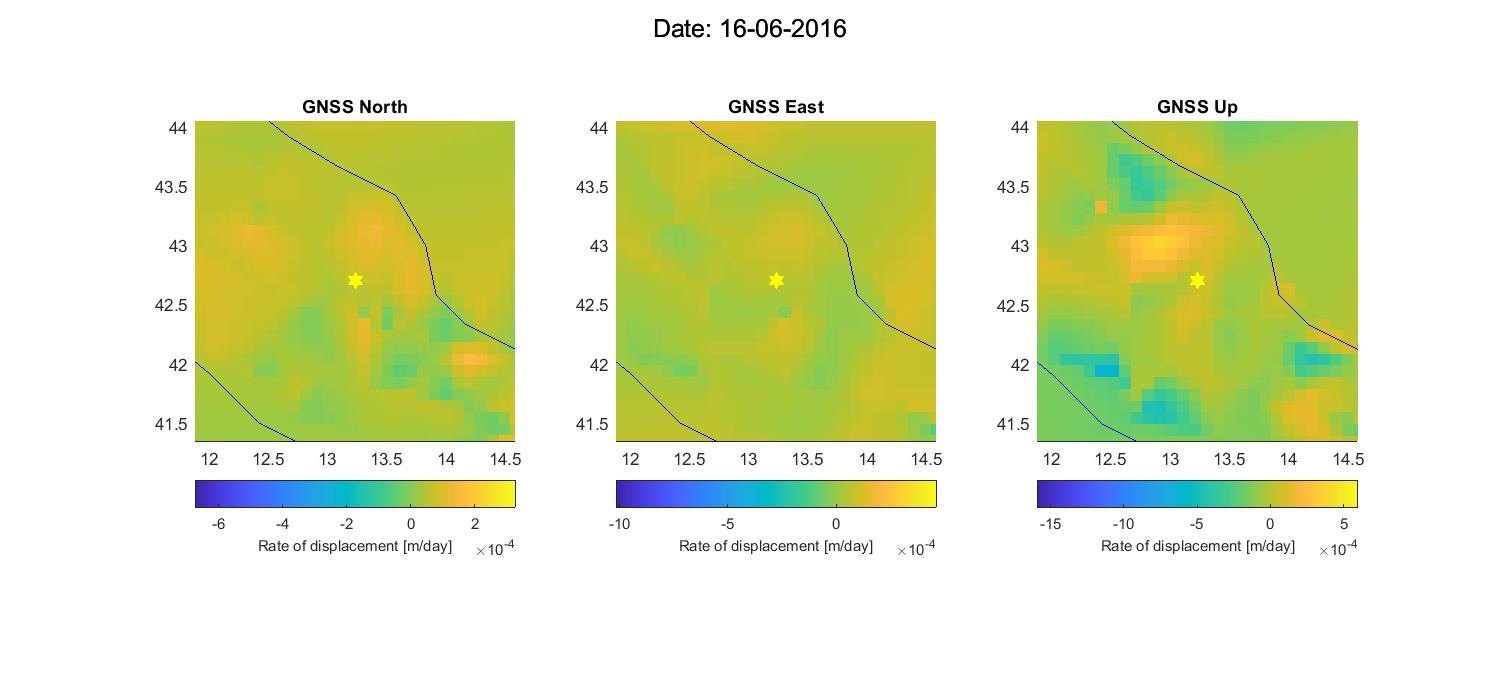

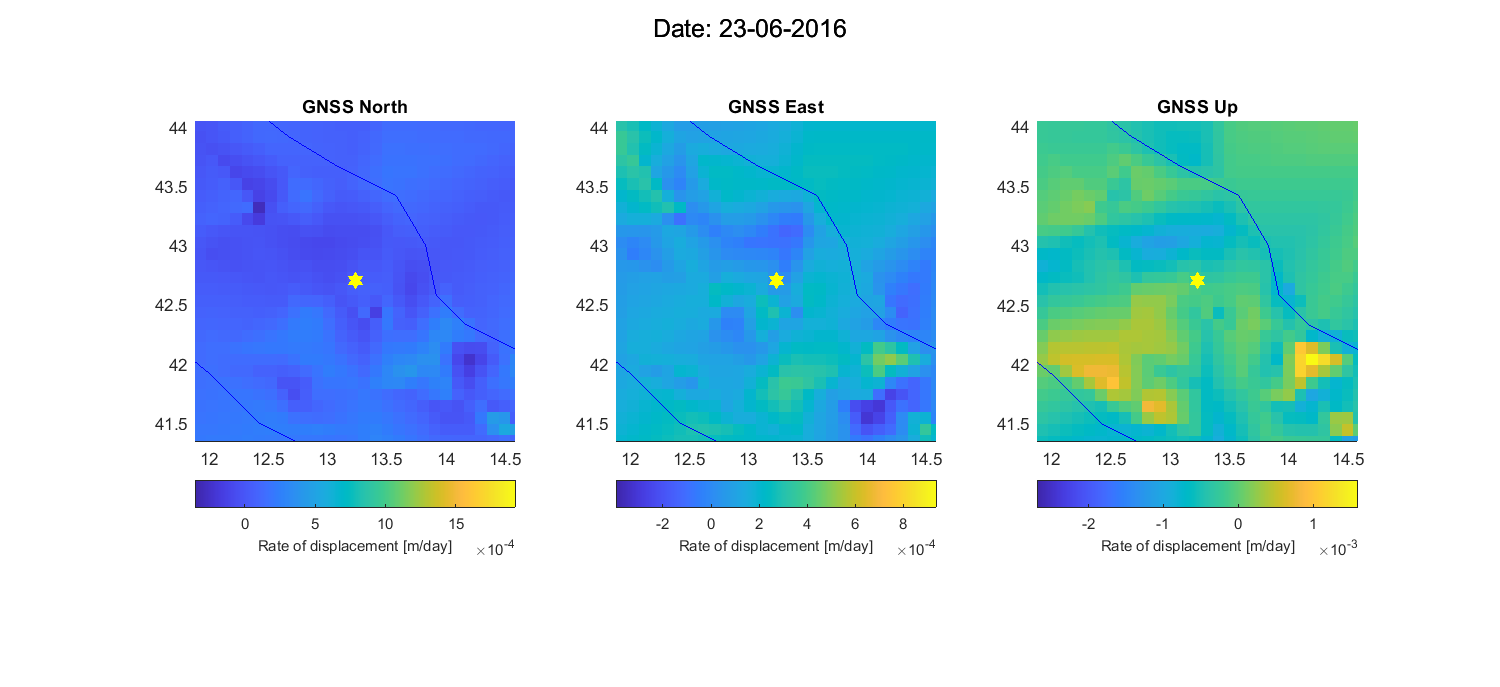

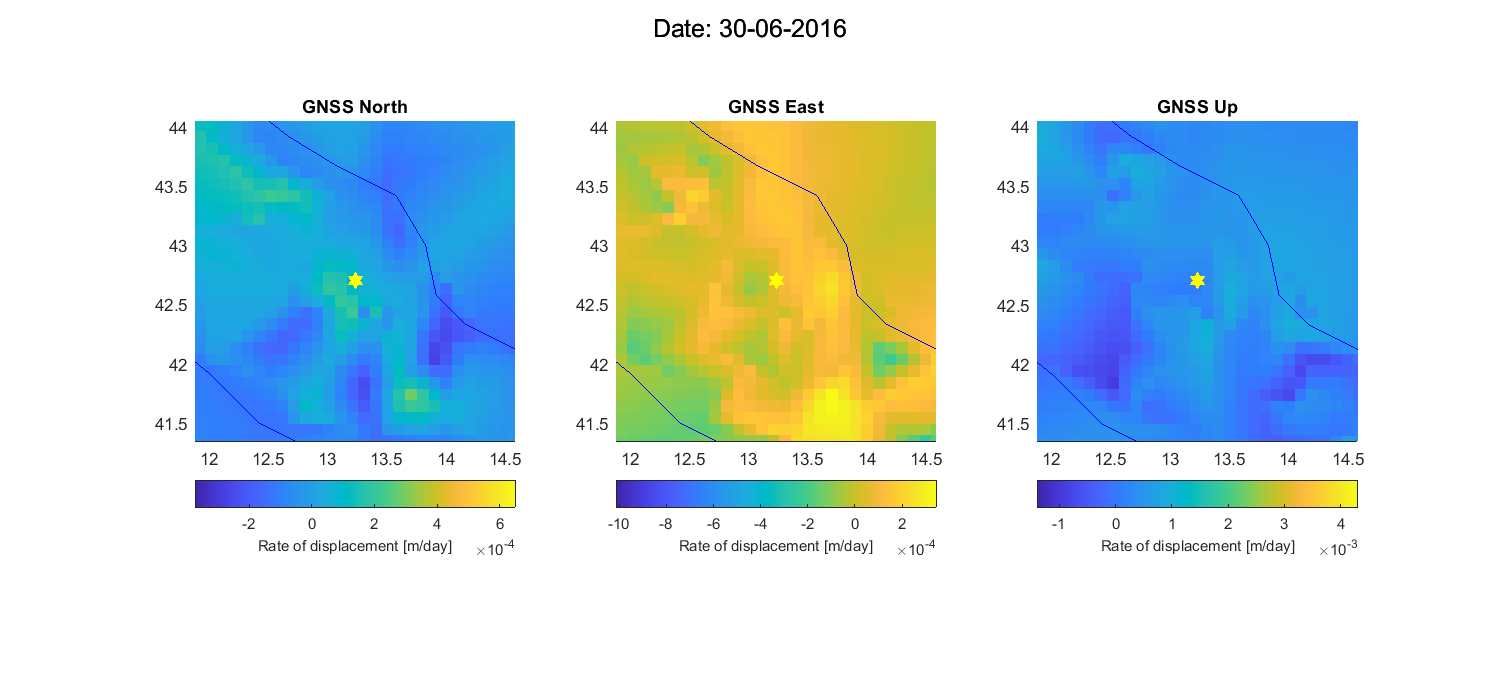

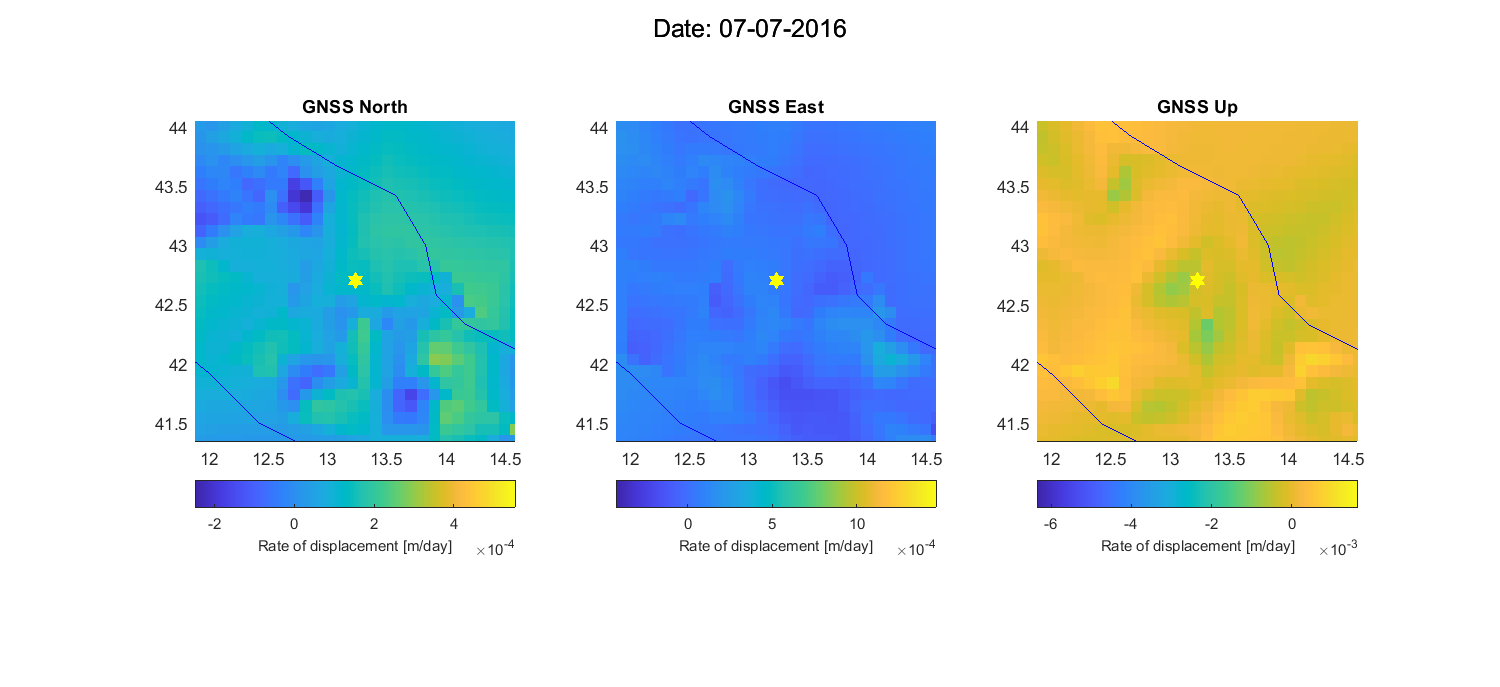

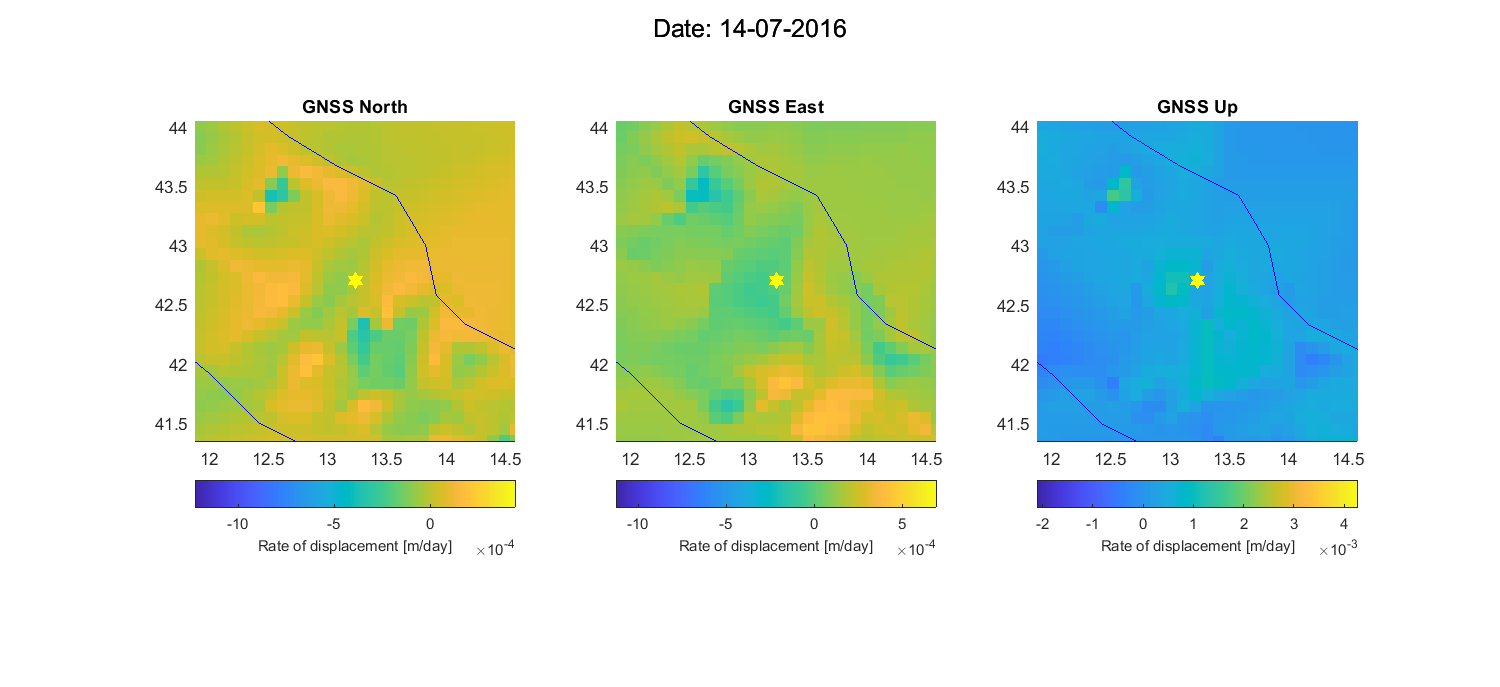

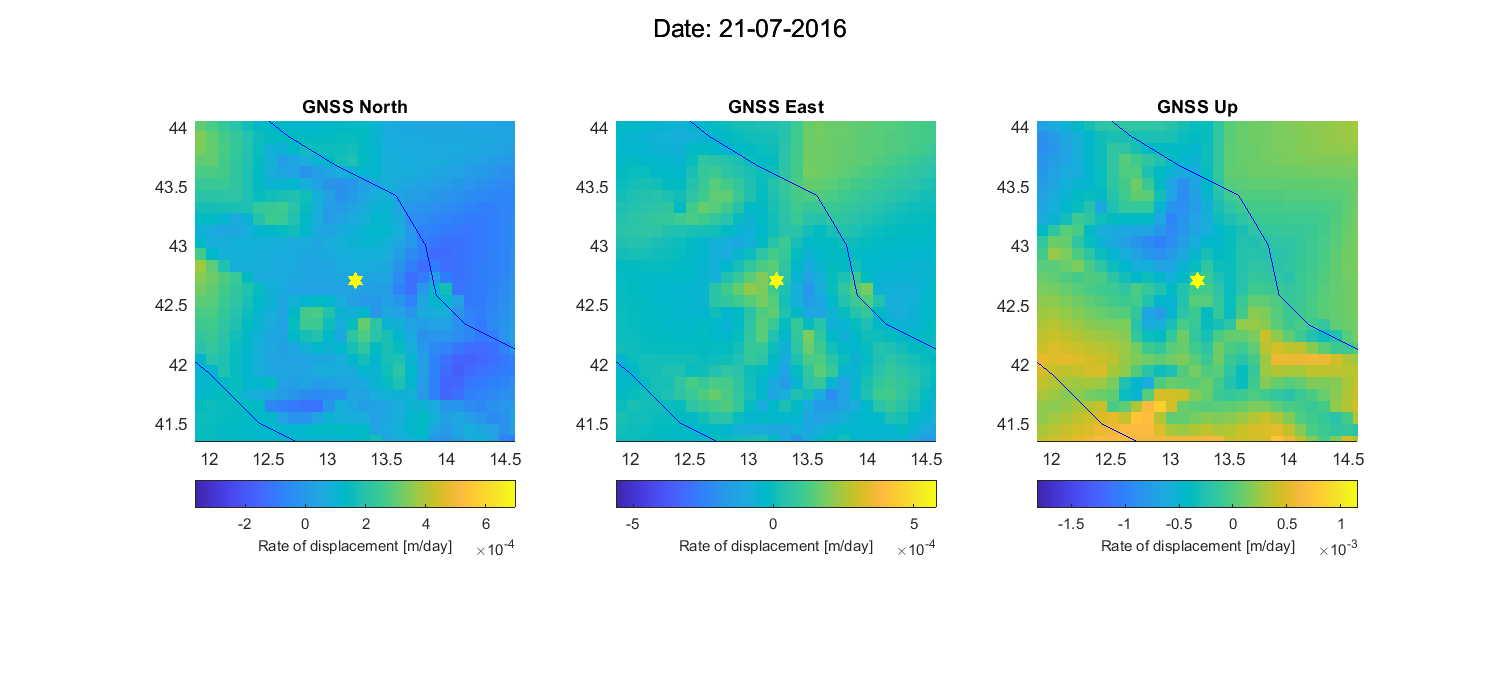

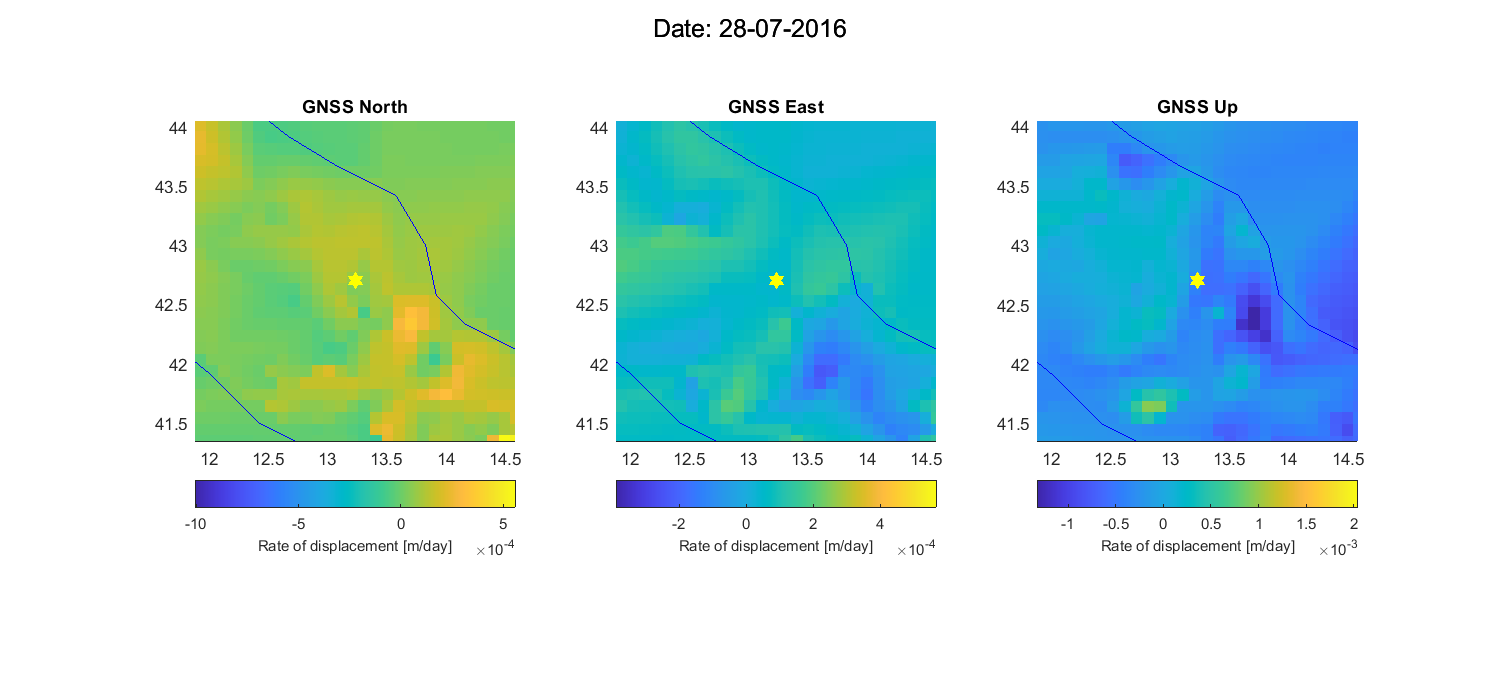

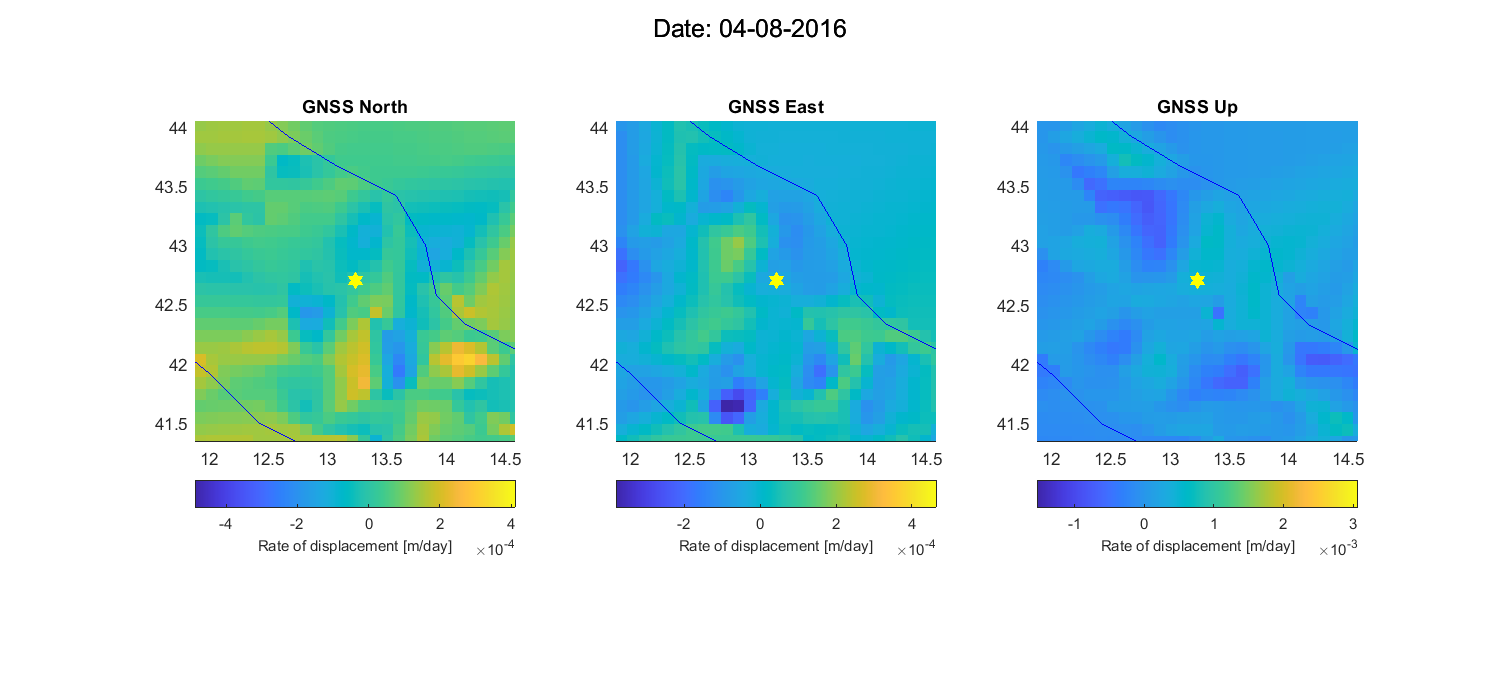

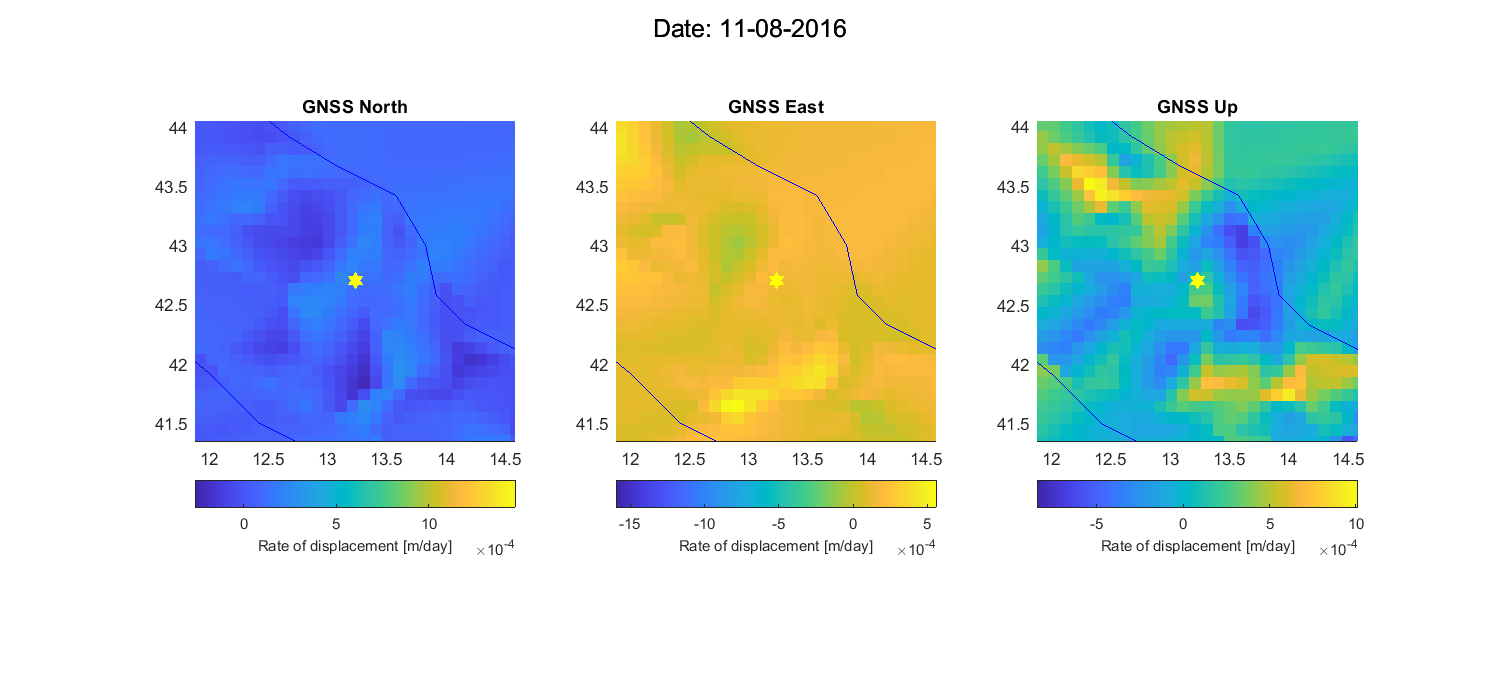

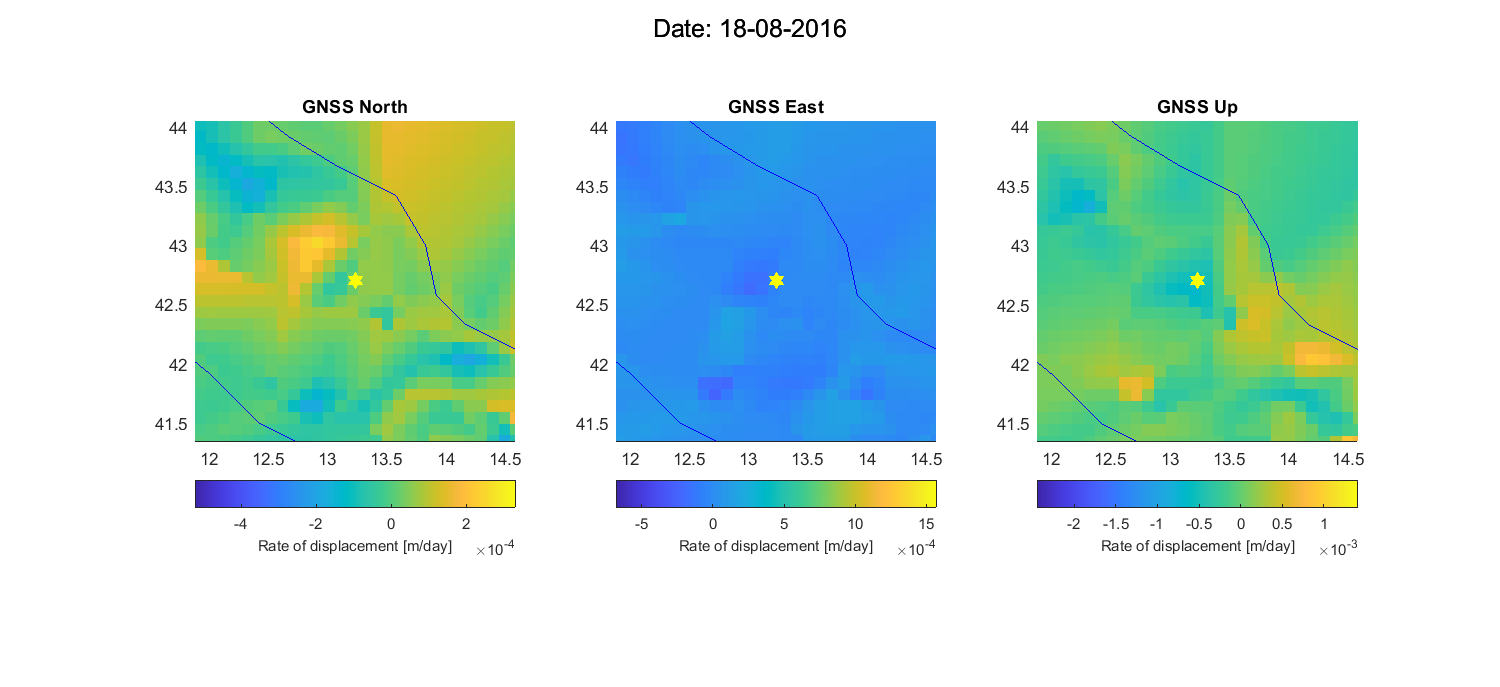

In [10]:
GNSS_timestamp = nan(size(data_from_GNSS, 1)*30,1);
k = 1;
for i = 1:size(data_from_GNSS, 1)
    timestamp_1 = data_from_GNSS{i}.data(:,1);
    GNSS_timestamp(k:k+size(timestamp_1,1)-1) = timestamp_1;
    k = k + size(timestamp_1,1);
end
GNSS_timestamp = GNSS_timestamp(1:k-1);
GNSS_timestamp = unique(GNSS_timestamp);

GNSS_all_data = nan(size(GNSS_timestamp,1), size(data_from_GNSS, 1), 3);
for i = 1:size(data_from_GNSS,1)
    GNSS_station_1 = data_from_GNSS{i}.data;
    time_stamp_station = GNSS_station_1(:,1);
    for k = 1:size(GNSS_timestamp,1)
        data_to_be_assigned = GNSS_station_1(time_stamp_station == GNSS_timestamp(k),2:4);
        if size(data_to_be_assigned,1)>0
            GNSS_all_data(k,i,:) =data_to_be_assigned;
        end
    end
end

%filling missing values with interpolated values
% for k = 2:size(GNSS_timestamp,1)-1
%    for i = 1:size(data_from_GNSS,1)
%        for j = 1:3
%            if isnan(GNSS_all_data(k,i,j))
%                previous_data = GNSS_all_data(k-1,i,j);
%                next_data = GNSS_all_data(k+1,i,j);
%                if isfinite(previous_data) && isfinite(next_data)
%                    GNSS_all_data(k,i,j) = interp1([GNSS_timestamp(k-1), GNSS_timestamp(k+1)], [previous_data, next_data], GNSS_timestamp(k), 'linear'); 
%                end
%            end
%        end
%    end
% end

station_good = nan(size(data_from_GNSS,1), 1);
station_coordinates = nan(size(data_from_GNSS,1), 2);
for i = 1:size(data_from_GNSS,1)
    if sum(isnan(GNSS_all_data(:,i,1)) | GNSS_all_data(:,i,1) == 0) >= size(GNSS_all_data,1) - 1
        station_good(i,1) = 0;
    else
        station_good(i,1) = 1;
    end
    station_coordinates(i,1:2) = data_from_GNSS{i}.coordinates;
end
GNSS_all_data = GNSS_all_data(:, station_good == 1, :);
station_coordinates = station_coordinates(station_good == 1, :);

for i = 1:size(GNSS_all_data,2)
    for j = 1:3
        data_to_be_analysed = GNSS_all_data(:,i,j);
        time_of_data_to_be_analysed = GNSS_timestamp(isfinite(data_to_be_analysed));
        data_to_be_analysed = data_to_be_analysed(isfinite(data_to_be_analysed));
        data_interpolated = interp1(time_of_data_to_be_analysed, data_to_be_analysed, GNSS_timestamp, 'linear');
        GNSS_all_data(:,i,j) = data_interpolated;
    end
end

min_lat_GNSS = min(station_coordinates(:,2));
max_lat_GNSS = max(station_coordinates(:,2));
min_lon_GNSS = min(station_coordinates(:,1));
max_lon_GNSS = max(station_coordinates(:,1));
resolution_GNSS = 0.1; %Resolution of maps from GNSS data

lon_vector = min_lon_GNSS:resolution_GNSS:max_lon_GNSS;
lat_vector = min_lat_GNSS:resolution_GNSS:max_lat_GNSS;
[grid_LAT, grid_LON] = meshgrid(lat_vector, lon_vector);
load coastlines;

GNSS_all_data_diff = diff(GNSS_all_data, 1, 1);
GNSS_timestamp_diff = GNSS_timestamp(1:end-1)/2 + GNSS_timestamp(2:end)/2;
for i = 1:size(GNSS_all_data_diff,1)
    GNSS_all_data_diff(i,:,:) = GNSS_all_data_diff(i,:,:) ./ (GNSS_timestamp(i+1)-GNSS_timestamp(i));
    data_for_map = reshape(GNSS_all_data_diff(i,:,:), size(GNSS_all_data_diff, 2), size(GNSS_all_data_diff, 3));
    station_coordinates_p = station_coordinates(isfinite(data_for_map(:,1)), :);
    data_for_map = data_for_map(isfinite(data_for_map(:,1)), :);
    F_N = scatteredInterpolant(station_coordinates_p(:,2), station_coordinates_p(:,1), data_for_map(:,1));
    F_E = scatteredInterpolant(station_coordinates_p(:,2), station_coordinates_p(:,1), data_for_map(:,2));
    F_U = scatteredInterpolant(station_coordinates_p(:,2), station_coordinates_p(:,1), data_for_map(:,3));
    interpolated_data_N = F_N(grid_LAT, grid_LON);
    interpolated_data_E = F_E(grid_LAT, grid_LON);
    interpolated_data_U = F_U(grid_LAT, grid_LON);
    figure('Position', [1 1 1200 550])
    subplot(1,3,1)
    geoshow(grid_LAT, grid_LON, interpolated_data_N, 'DisplayType', 'texturemap');
    hold on
    plot(coastlon, coastlat, '-b');
    plot(epilon, epilat, 'hy', 'MarkerSize', 10, 'MarkerFaceColor', 'y');
    axis([epilon-Maximum_distance/111 epilon+Maximum_distance/111 epilat-Maximum_distance/111 epilat+Maximum_distance/111]); 
    title('GNSS North');
    h = colorbar('southoutside');
    xlabel(h, 'Rate of displacement [m/day]');
    subplot(1,3,2)
    geoshow(grid_LAT, grid_LON, interpolated_data_E, 'DisplayType', 'texturemap');
    hold on;
    plot(coastlon, coastlat, '-b');
    plot(epilon, epilat, 'hy', 'MarkerSize', 10, 'MarkerFaceColor', 'y');
    axis([epilon-Maximum_distance/111 epilon+Maximum_distance/111 epilat-Maximum_distance/111 epilat+Maximum_distance/111]); 
    title('GNSS East');
    h = colorbar('southoutside');
    xlabel(h, 'Rate of displacement [m/day]');
    subplot(1,3,3)
    geoshow(grid_LAT, grid_LON, interpolated_data_U, 'DisplayType', 'texturemap');
    hold on
    plot(coastlon, coastlat, '-b');
    plot(epilon, epilat, 'hy', 'MarkerSize', 10, 'MarkerFaceColor', 'y');
    axis([epilon-Maximum_distance/111 epilon+Maximum_distance/111 epilat-Maximum_distance/111 epilat+Maximum_distance/111]); 
    title('GNSS Up');
    h = colorbar('southoutside');
    xlabel(h, 'Rate of displacement [m/day]');
    sgtitle(['Date: ', datestr(GNSS_timestamp_diff(i), 'dd-mm-yyyy')]);
end



## Atmospheric analysis

The atmospheric analysis uses a method called MEANS which is a variation of CAPRI algoritms. A full description of the methods can be found in:  
1. Piscini, A.; De Santis, A.; Marchetti, D.; Cianchini, G. A Multi-Parametric Climatological Approach to Study the 2016 Amatrice–Norcia (Central Italy) Earthquake Preparatory Phase. Pure Appl. Geophys. 2017, 174, 3673–3688. <a href="https://doi.org/10.1007/s00024-017-1597-8">doi:10.1007/s00024-017-1597-8</a>.
2. Marchetti, D.; De Santis, A.; Shen, X.; Campuzano, S.A.; Perrone, L.; Piscini, A.; Di Giovambattista, R.; Jin, S.; Ippolito, A.; Cianchini, G.; et al. Possible Lithosphere-Atmosphere-Ionosphere Coupling Effects Prior to the 2018 Mw = 7.5 Indonesia Earthquake from Seismic, Atmospheric and Ionospheric Data. J. Asian Earth Sci. 2020, 188, 104097. <a href="https://doi.org/10.1016/j.jseaes.2019.104097">doi:10.1016/j.jseaes.2019.104097</a>.


The atmospheric analysis uses the MERRA2 climatological archive data from NASA (doi: <a href="https://doi.org/10.5067/KLICLTZ8EM9D"> 10.5067/KLICLTZ8EM9D</a>).  
This version of the VRE uses data that were downloaded and pre-processed. In future releases, the automatic download of the dataset will be provided.

The pre-processed data are inside the file "Atmospheric_data_for_Norcia.mat".

number_of_analysed_days = 241

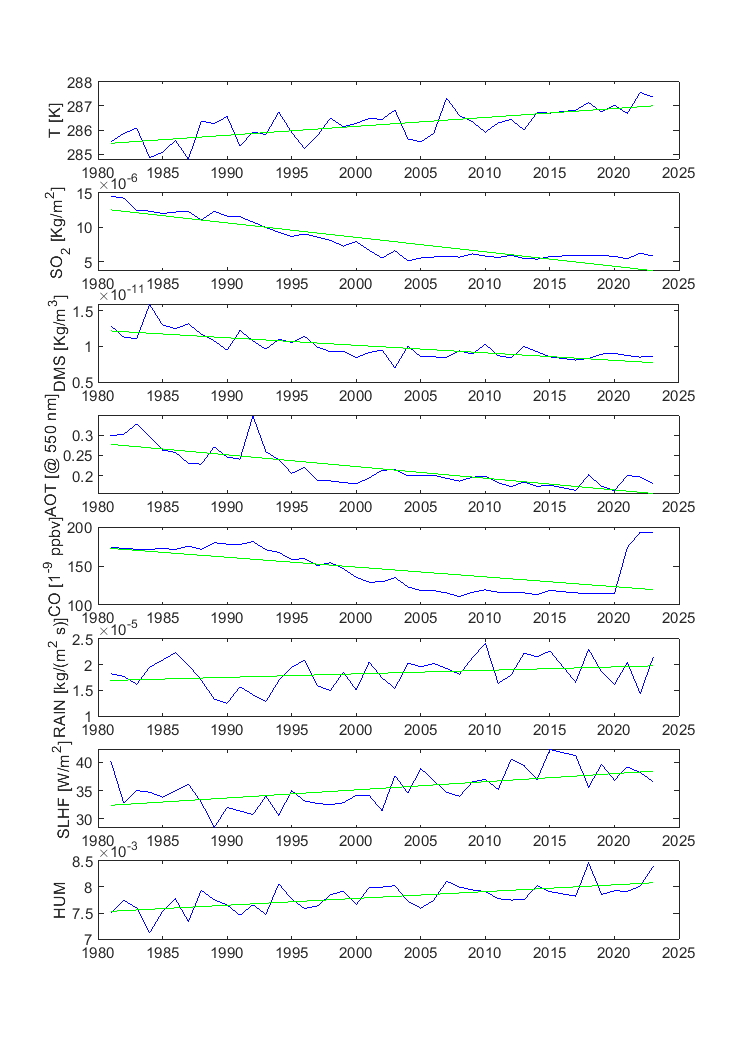

In [22]:
load(fullfile('data', 'Atmospheric_data_for_Norcia.mat'));
global_warming_correction = 1;
time_start = EQ_time - day_before;
time_end = EQ_time + day_after;
number_of_analysed_days = time_end - time_start + 1
[year_end1, month_end1, day_end1] = datevec(time_end);
year_end = 2023;
if (datenum([1980 month_end1 day_end1]) - number_of_analysed_days) < datenum([1980 1 1])
    year_start = 1981;
else
    year_start = 1980;
end
year_to_be_analysed = year_end-year_start;
mean_SO2 = nan(number_of_analysed_days,year_to_be_analysed);
mean_DMS = nan(number_of_analysed_days,year_to_be_analysed);
mean_AOT = nan(number_of_analysed_days,year_to_be_analysed);
mean_CO = nan(number_of_analysed_days,year_to_be_analysed);
mean_SAT = nan(number_of_analysed_days, year_to_be_analysed);
mean_HUM = nan(number_of_analysed_days,year_to_be_analysed);
mean_SLHF = nan(number_of_analysed_days,year_to_be_analysed);
mean_RAIN = nan(number_of_analysed_days,year_to_be_analysed);
mean_SO2_anno_EQ = zeros(number_of_analysed_days, 1);
mean_DMS_anno_EQ  = zeros(number_of_analysed_days, 1);
mean_AOT_anno_EQ  = zeros(number_of_analysed_days, 1);
mean_CO_anno_EQ  = zeros(number_of_analysed_days, 1);
mean_SAT_anno_EQ  = zeros(number_of_analysed_days, 1);
mean_HUM_anno_EQ  = zeros(number_of_analysed_days, 1);
mean_SLHF_anno_EQ  = zeros(number_of_analysed_days, 1);
mean_RAIN_anno_EQ  = zeros(number_of_analysed_days, 1);

SO2_EQ = SO2;
DMS_EQ = DMS;
AOT_EQ = AOT;
CO_EQ = CO;
SAT_EQ = SAT;
HUM_EQ = HUM;
SLHF_EQ = SLHF;
RAIN_EQ = RAIN;

anno_arr = 1;
for year_i=year_to_be_analysed:-1:0 % anno=anno_inizio:anno_fine
    anno = year_end-year_i;
    %     day_tbc = giorni_prima;
    data_fine = datenum([anno EQ_month EQ_day]);
    data_inizio = data_fine - number_of_analysed_days+1;
    if EQ_month == 1 || (EQ_month == 2 && EQ_day < 29)
        year_to_be_checked_for_leap = anno - 1;
    else
        year_to_be_checked_for_leap = anno;
    end
    Leap_day = datenum([year_to_be_checked_for_leap 2 29]);
    [~, ~, day_check] = datevec(Leap_day);
    if day_check == 29 && data_inizio <= Leap_day && data_fine >= Leap_day
        data_inizio = data_inizio - 1;
    end
    
    giorno_arr = 1;
    
    for i=data_inizio:data_fine
        [~, mese_p, giorno_p] = datevec(i);
        index_data = find(time_atmospheric_data == i);
        if not(mese_p == 2 && giorno_p == 29)
            
            
            % , SO2_EQ, DMS_EQ, AOT_EQ, CO_EQ, SAT_EQ, HUM_EQ, SLHF_EQ,
            % RAIN_EQ time_atmospheric_data
            
            if anno == EQ_year
                mean_SO2_anno_EQ(giorno_arr,1) = SO2_EQ(index_data);
                mean_DMS_anno_EQ(giorno_arr,1) = DMS_EQ(index_data);
                mean_AOT_anno_EQ(giorno_arr,1) = AOT_EQ(index_data);
                mean_CO_anno_EQ(giorno_arr,1) = CO_EQ(index_data);
                mean_SAT_anno_EQ(giorno_arr,1) = SAT_EQ(index_data);
                mean_RAIN_anno_EQ(giorno_arr,1) = RAIN_EQ(index_data);
                mean_SLHF_anno_EQ(giorno_arr,1) = SLHF_EQ(index_data);
                mean_HUM_anno_EQ(giorno_arr,1) = HUM_EQ(index_data);
            else
                mean_SO2(giorno_arr,anno_arr) = SO2_EQ(index_data);
                mean_DMS(giorno_arr,anno_arr) = DMS_EQ(index_data);
                mean_AOT(giorno_arr,anno_arr) = AOT_EQ(index_data);
                mean_CO(giorno_arr,anno_arr) = CO_EQ(index_data);
                mean_SAT(giorno_arr,anno_arr) = SAT_EQ(index_data);
                mean_RAIN(giorno_arr,anno_arr) = RAIN_EQ(index_data);
                mean_SLHF(giorno_arr,anno_arr) = SLHF_EQ(index_data);
                mean_HUM(giorno_arr,anno_arr) = HUM_EQ(index_data);
            end
            
            giorno_arr = giorno_arr + 1;
        end
    end
    if anno ~= EQ_year
        anno_arr = anno_arr + 1;
    end
end
if global_warming_correction == 0
    yarly_SAT = (mean(mean_SAT,1))';
    yarly_SAT = yarly_SAT(1:end-1);
    year_considered = (year_start:year_end)';
    year_considered = year_considered(year_considered ~= EQ_year);
    fit_global_warming_SAT = polyfit(year_considered,yarly_SAT,1);
    year_k = 1;
    for year_tbcorrected = year_start:year_end
        if year_tbcorrected ~= EQ_year
            mean_SAT(:,year_k) = mean_SAT(:,year_k) - fit_global_warming_SAT(1)*(year_tbcorrected - year_start);
        else
            mean_SAT_anno_EQ = mean_SAT_anno_EQ - fit_global_warming_SAT(1)*(year_tbcorrected - year_start);
        end
        year_k = year_k + 1;
    end
elseif global_warming_correction > 0
    yarly_SAT = (mean(mean_SAT,1))';
    yarly_SO2 = (mean(mean_SO2,1))';
    yarly_DMS = (mean(mean_DMS,1))';
    yarly_AOT = (mean(mean_AOT,1))';
    yarly_CO = (mean(mean_CO,1))';
    yarly_RAIN = (mean(mean_RAIN,1))';
    yarly_SLHF = (mean(mean_SLHF,1))';
    yarly_HUM = (mean(mean_HUM,1))';
    year_considered = (year_start:year_end)';
    year_considered = year_considered(year_considered ~= EQ_year);
    
    fit_global_warming_SAT = polyfit(year_considered,yarly_SAT,global_warming_correction);
    fit_global_warming_SO2 = polyfit(year_considered,yarly_SO2,global_warming_correction);
    fit_global_warming_DMS = polyfit(year_considered,yarly_DMS,global_warming_correction);
    fit_global_warming_AOT = polyfit(year_considered,yarly_AOT,global_warming_correction);
    fit_global_warming_CO = polyfit(year_considered,yarly_CO,global_warming_correction);
    fit_global_warming_RAIN = polyfit(year_considered,yarly_RAIN,global_warming_correction);
    fit_global_warming_SLHF = polyfit(year_considered,yarly_SLHF,global_warming_correction);
    fit_global_warming_HUM = polyfit(year_considered,yarly_HUM,global_warming_correction);

        figure('Position', [1,1,600,1500])
        subplot(8,1,1)
        plot(year_considered,yarly_SAT, '-b');
        hold on;
        plot(year_considered,polyval(fit_global_warming_SAT, year_considered), '-g');
        ylabel('T [K]');
        subplot(8,1,2)
        plot(year_considered,yarly_SO2, '-b');
        hold on;
        plot(year_considered,polyval(fit_global_warming_SO2, year_considered), '-g');
        ylabel('SO_2 [Kg/m^2]');
        subplot(8,1,3)
        plot(year_considered,yarly_DMS, '-b');
        hold on;
        plot(year_considered,polyval(fit_global_warming_DMS, year_considered), '-g');
        ylabel('DMS [Kg/m^3]');
        subplot(8,1,4)
        plot(year_considered,yarly_AOT, '-b');
        hold on;
        plot(year_considered,polyval(fit_global_warming_AOT, year_considered), '-g');
        ylabel('AOT [@ 550 nm]');
        subplot(8,1,5)
        plot(year_considered,yarly_CO, '-b');
        hold on;
        plot(year_considered,polyval(fit_global_warming_CO, year_considered), '-g');
        ylabel('CO [1^{-9} ppbv]');
        subplot(8,1,6)
        plot(year_considered,yarly_RAIN, '-b');
        hold on;
        plot(year_considered,polyval(fit_global_warming_RAIN, year_considered), '-g');
        ylabel('RAIN [kg/(m^2 s)]');
        subplot(8,1,7)
        plot(year_considered,yarly_SLHF, '-b');
        hold on;
        plot(year_considered,polyval(fit_global_warming_SLHF, year_considered), '-g');
        ylabel('SLHF [W/m^2]');
        subplot(8,1,8)
        plot(year_considered,yarly_HUM, '-b');
        hold on;
        plot(year_considered,polyval(fit_global_warming_HUM, year_considered), '-g');
        ylabel('HUM');


        year_k = 1;
    for year_tbcorrected = year_start:year_end
        if year_tbcorrected ~= EQ_year
            mean_SAT(:,year_k) = mean_SAT(:,year_k) - polyval(fit_global_warming_SAT, year_tbcorrected) + mean(mean_SAT(:,1));
            mean_SO2(:,year_k) = mean_SO2(:,year_k) - polyval(fit_global_warming_SO2, year_tbcorrected) + mean(mean_SO2(:,1));
            mean_DMS(:,year_k) = mean_DMS(:,year_k) - polyval(fit_global_warming_DMS, year_tbcorrected) + mean(mean_DMS(:,1));
            mean_AOT(:,year_k) = mean_AOT(:,year_k) - polyval(fit_global_warming_AOT, year_tbcorrected) + mean(mean_AOT(:,1));
            mean_CO(:,year_k) = mean_CO(:,year_k) - polyval(fit_global_warming_CO, year_tbcorrected) + mean(mean_CO(:,1));
            mean_RAIN(:,year_k) = mean_RAIN(:,year_k) - polyval(fit_global_warming_RAIN, year_tbcorrected) + mean(mean_RAIN(:,1));
            mean_SLHF(:,year_k) = mean_SLHF(:,year_k) - polyval(fit_global_warming_SLHF, year_tbcorrected) + mean(mean_SLHF(:,1));
            mean_HUM(:,year_k) = mean_HUM(:,year_k) - polyval(fit_global_warming_HUM, year_tbcorrected) + mean(mean_HUM(:,1));
            year_k = year_k + 1;
        else
            mean_SAT_anno_EQ = mean_SAT_anno_EQ - polyval(fit_global_warming_SAT, year_tbcorrected) + mean(mean_SAT(:,1));
            mean_SO2_anno_EQ = mean_SO2_anno_EQ - polyval(fit_global_warming_SO2, year_tbcorrected) + mean(mean_SO2(:,1));
            mean_DMS_anno_EQ = mean_DMS_anno_EQ - polyval(fit_global_warming_DMS, year_tbcorrected) + mean(mean_DMS(:,1));
            mean_AOT_anno_EQ = mean_AOT_anno_EQ - polyval(fit_global_warming_AOT, year_tbcorrected) + mean(mean_AOT(:,1));
            mean_CO_anno_EQ = mean_CO_anno_EQ - polyval(fit_global_warming_CO, year_tbcorrected) + mean(mean_CO(:,1));
            mean_RAIN_anno_EQ = mean_RAIN_anno_EQ - polyval(fit_global_warming_RAIN, year_tbcorrected) + mean(mean_RAIN(:,1));
            mean_SLHF_anno_EQ = mean_SLHF_anno_EQ - polyval(fit_global_warming_SLHF, year_tbcorrected) + mean(mean_SLHF(:,1));
            mean_HUM_anno_EQ = mean_HUM_anno_EQ - polyval(fit_global_warming_HUM, year_tbcorrected) + mean(mean_HUM(:,1));
        end
        
    end
end

sd_SO2 = nanstd(mean_SO2, 0, 2);
sd_DMS = nanstd(mean_DMS, 0, 2);
sd_AOT = nanstd(mean_AOT, 0, 2);
sd_CO = nanstd(mean_CO, 0, 2);
sd_SAT = nanstd(mean_SAT, 0, 2);
sd_RAIN = nanstd(mean_RAIN, 0, 2);
sd_SLHF = nanstd(mean_SLHF, 0, 2);
sd_HUM = nanstd(mean_HUM, 0, 2);

soglia_SO2 = median(nanmedian(mean_SO2, 2)) + 10*median(sd_SO2);
soglia_DMS = median(nanmedian(mean_DMS, 2)) + 10*median(sd_DMS);
soglia_AOT = median(nanmedian(mean_AOT, 2)) + 10*median(sd_AOT);
soglia_CO = median(nanmedian(mean_CO, 2)) + 10*median(sd_CO);
soglia_SAT = median(nanmedian(mean_SAT, 2)) + 10*median(sd_SAT);
soglia_RAIN = median(nanmedian(mean_RAIN, 2)) + 10*median(sd_SAT);
soglia_SLHF = median(nanmedian(mean_SLHF, 2)) + 10*median(sd_SAT);
soglia_HUM = median(nanmedian(mean_SAT, 2)) + 10*median(sd_SAT);

mean_SO2h = []; %vettore per immaganizzare i dati "buoni"

mean_DMSh = [];
mean_AOTh = [];
mean_COh = [];
mean_SATh = [];
mean_RAINh = [];
mean_SLHFh = [];
mean_HUMh = [];

anni_esclusi_SO2 = [];
anni_esclusi_DMS = [];
anni_esclusi_AOT = [];
anni_esclusi_CO = [];
anni_esclusi_SAT = [];
anni_esclusi_RAIN = [];
anni_esclusi_SLHF = [];
anni_esclusi_HUM = [];

w=1;
for i=1:size(mean_SO2,2)
    if max(mean_SO2(:,i)) < soglia_SO2 %&& max(mean_SO2(:,i)) < soglia_SO2 %% max(mean_DMS(:,i)) < soglia_DMS &&
        mean_SO2h = [mean_SO2h, mean_SO2(:,i)];
    else
        anni_esclusi_SO2 = [anni_esclusi_SO2; year_start-1+i];
    end
    mean_DMSh = [mean_DMSh, mean_DMS(:,i)];
    if max(mean_AOT(:,i)) < soglia_AOT %% max(mean_DMS(:,i)) < soglia_DMS &&
        mean_AOTh = [mean_AOTh, mean_AOT(:,i)];
    else
        anni_esclusi_AOT = [anni_esclusi_AOT; year_start-1+i];
    end
    if max(mean_CO(:,i)) < soglia_CO % && max(mean_AOT(:,i)) < soglia_AOT %% max(mean_DMS(:,i)) < soglia_DMS &&
        mean_COh = [mean_COh, mean_CO(:,i)];
    else
        anni_esclusi_CO = [anni_esclusi_CO; year_start-1+i];
    end
    if max(mean_SAT(:,i)) < soglia_SAT
        mean_SATh = [mean_SATh, mean_SAT(:,i)];
    else
        anni_esclusi_SAT = [anni_esclusi_SAT; year_start-1+i];
    end
    mean_RAINh = [mean_RAINh, mean_RAIN(:,i)];
    mean_SLHFh = [mean_SLHFh, mean_SLHF(:,i)];
    mean_HUMh = [mean_HUMh, mean_HUM(:,i)];
end

sd_SO2 = nanstd(mean_SO2h, 0, 2);
mean_SO2 = nanmean(mean_SO2h, 2);
sd_DMS = nanstd(mean_DMSh, 0, 2);
mean_DMS = nanmean(mean_DMSh, 2);
sd_AOT = nanstd(mean_AOTh, 0, 2);
mean_AOT = nanmean(mean_AOTh, 2);
sd_CO = nanstd(mean_COh, 0, 2);
mean_CO = nanmean(mean_COh, 2);
sd_SAT = nanstd(mean_SATh, 0, 2);
mean_SAT = nanmean(mean_SATh, 2);
sd_RAIN = nanstd(mean_RAINh, 0, 2);
mean_RAIN = nanmean(mean_RAINh, 2);
sd_SLHF = nanstd(mean_SLHFh, 0, 2);
mean_SLHF = nanmean(mean_SLHFh, 2);
sd_HUM = nanstd(mean_HUMh, 0, 2);
mean_HUM = nanmean(mean_HUMh, 2);

atmospheric_anomalies = []; %1 SO2, 2 DMS, 3 AOT, 4 CO, 5 Temp., 6 SLHF, 7 HUM
for i=1:size(mean_SO2, 1)
    if (mean_SO2_anno_EQ(i) > (mean_SO2(i) + 2 * sd_SO2(i)))
        atmospheric_anomalies = [atmospheric_anomalies; i, 1];
    end
    if (mean_DMS_anno_EQ(i) > (mean_DMS(i) + 2 * sd_DMS(i)))
        atmospheric_anomalies = [atmospheric_anomalies; i, 2];
    end
    if (mean_AOT_anno_EQ(i) > (mean_AOT(i) + 2 * sd_AOT(i)))
        atmospheric_anomalies = [atmospheric_anomalies; i, 3];
    end
    if (mean_CO_anno_EQ(i) > (mean_CO(i) + 2 * sd_CO(i)))
        atmospheric_anomalies = [atmospheric_anomalies; i, 4];
    end
    if (mean_SAT_anno_EQ(i) > (mean_SAT(i) + 2 * sd_SAT(i)))
        atmospheric_anomalies = [atmospheric_anomalies; i, 5];
    end
    if (mean_SLHF_anno_EQ(i) > (mean_SLHF(i) + 2 * sd_SLHF(i)))
        atmospheric_anomalies = [atmospheric_anomalies; i, 6];
    end
    if (mean_HUM_anno_EQ(i) < (mean_HUM(i) - 2 * sd_HUM(i)))
        atmospheric_anomalies = [atmospheric_anomalies; i, 7];
    end
end

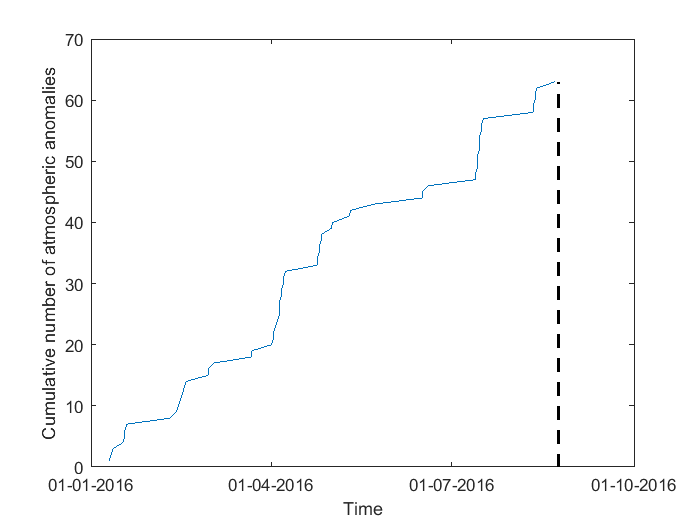

In [23]:
figure
atmospheric_anomalies = sortrows(atmospheric_anomalies,1);
cumulate_atmosphere = (1:size(atmospheric_anomalies, 1))';
plot(time_start-1+atmospheric_anomalies(:,1), cumulate_atmosphere)
line([EQ_time, EQ_time], [0 cumulate_atmosphere(end)], 'LineStyle', '--', 'LineWidth', 2, 'Color', 'k');
datetick('x', 'dd-mm-yyyy');
xlabel('Time');
ylabel('Cumulative number of atmospheric anomalies');

## Ionospheric analysis
In this session, the magnetic data from Swarm three-identical satellites are analysed.

Data must be downloaded from ESA's ftp dissemination service, which requires a free EO user account (you can create one here: https://eoiam-idp.eo.esa.int/) and placed in one folder of your computer were the VRE is running.

In the following example the data are inside the folder **ndir** = E:\Swarm_data  
The ESA Swarm file names appear as:  
SW_OPER_MAGA_LR_1B_20131125T110252_20131125T235959_0602_MDR_MAG_LR.cdf  
SW_OPER_MAGA_LR_1B_20201027T134456_20201027T150128_0605_MDR_MAG_LR.cdf  
...  
SW_OPER_MAGC_LR_1B_20140524T000000_20140524T235959_0602_MDR_MAG_LR.cdf


A full description of the method used for this analysis can be found in the following papers:
1. De Santis, A.; Balasis, G.; Pavón-Carrasco, F.J.; Cianchini, G.; Mandea, M. Potential earthquake precursory pattern from space: The 2015 Nepal event as seen by magnetic Swarm satellites. Earth Planet. Sci. Lett. 2017, 461, 119–126. <a href="http://doi.org/10.1016/j.epsl.2016.12.037"> doi:10.1016/j.epsl.2016.12.037</a>.
2. De Santis, A.; Marchetti, D.; Pavón-Carrasco, F.J.; Cianchini, G.; Perrone, L.; Abbattista, C.; Alfonsi, L.; Amoruso, L.; Campuzano, S.A.; Carbone, M.; et al. Precursory worldwide signatures of earthquake occurrences on Swarm satellite data. Sci. Rep. 2019, 9, 20287. <a href="http://doi.org/10.1038/s41598-019-56599-1">doi:10.1038/s41598-019-56599-1</a>.  
3. Marchetti, D.; De Santis, A.; Campuzano, S.A.; Zhu, K.; Soldani, M.; D’Arcangelo, S.; Orlando, M.; Wang, T.; Cianchini, G.; Di Mauro, D.; et al. Worldwide Statistical Correlation of Eight Years of Swarm Satellite Data with M5.5+ Earthquakes: New Hints about the Preseismic Phenomena from Space. Remote Sens. 2022, 14, 2649. <a href="https://doi.org/10.3390/rs14112649">doi:10.3390/rs14112649</a>.


The first part of the following code selects the data in the time range defined for the analysis of the earthquake.

In [28]:
threshold = 4; %Threshold to identify Swarm magnetic anomalies
width_window = 3; %Lenght of the latitudinal window to search for anomalies

addpath('extra_code');

EQ_time = datenum([EQ_year, EQ_month, EQ_day, EQ_hour, EQ_minute, EQ_second]);
time_start = EQ_time - day_before;
time_end = EQ_time + day_after;

YYYY = EQ_year;
MM = EQ_month;
DD = EQ_day;
DB = day_before;
DA = day_after;

ndir = 'E:\Swarm_data/';
files = dir([ndir, 'SW_OPER_MAG*cdf']);
files = {files.name}';

k=1;
newfiles={};
for i=1:size(files,1)
    a=files{i};
    t=datenum([str2double(a(20:23)),str2double(a(24:25)),str2double(a(26:27))]);
    if t>=time_start && t<=time_end
        newfiles(k,:)=files(i);
        k = k + 1;
    end
end


The following code extracts the Swarm magnetic data inside the Dobrovolsky's area and stores in struct variable **"tracks"** for further processing.  
Total number of extracted tracks is shown as i_tr

In [29]:
idst=load('data/dst_index2.dat');
iap=load('data/ap_index2.dat');
load('data/Solar_activity_SW_and_F_1min.mat');
radius_Dobrovolsky = 10.^(0.43*EQ_mag)/111;

tracks = {};
i_tr = 1;
for i=1:10 %size(newfiles,1) %This is stopped to the first 10 files as it doesn't work in Jupyter, but it may run in Matlab.
    a=newfiles{i};
    x=cdfread(fullfile(ndir,newfiles{i}), 'Variable', {'Timestamp', 'Latitude', 'Longitude', 'Radius', 'Flags_F', 'Flags_B', 'Flags_q', 'Flags_Platform', 'B_NEC', 'F'}, 'ConvertEpochToDatenum', true);%Read the .cdf.dat file.
    y = nan(size(x,1), 17);
    for k = 1:size(x, 1)
        y(k,:) = [double(datevec(x{k,1})), double(cell2mat(x(k,2:4))), double(cell2mat(x(k,5:7))), double(cell2mat(x(k,8))), double(cell2mat(x(k,9))'), double(cell2mat(x(k,10)))];
    end
    yn=dat_orden_alpha(y,a(12));% Include the number of track for each day
    y=yn( abs(yn(:,10)-epilon)<=(radius_Dobrovolsky+15),:);
    if size(y,1) > 50
        tracks{i_tr} = y;
        i_tr = i_tr + 1;
    end
end
i_tr = i_tr - 1;
i_tr

save('data/tracks.mat', 'tracks');

i_tr = 10

The following section calculated the magnetic residual along the tracks. The residual of the magnetic field in this case is the part of data that may contains eventual non ordinary signals, i.e. eventual earthquake induced signals.  

In [37]:
format compact
load(fullfile("data", "tracks.mat")); %this file provides the full set of files and not only the first 100
residuals = {};
i_res = 1;
for i=1:size(tracks,2)
    y = tracks{i};
    p1=y(1,8):y(end,8);
    for j=1:length(p1)
        z=y(y(:,8)==p1(j),:); %select the data of a specific track
        if size(z,1)>10 %if the track is longer than 10 data
            [dst,ap]=geomagnetic_indexes(z(1,2:5),idst,iap);
            z=sortrows(z,9);
            tt1=z(abs(z(:,9)-epilat)<radius_Dobrovolsky,5)+z(abs(z(:,9)-epilat)<radius_Dobrovolsky,6)/60+z(abs(z(:,9)-epilat)<radius_Dobrovolsky,7)/3600;%UTC TIME in decimal hour for the track
            tt1_v=datevec(mean(tt1)/24);
            delta_solar_time = abs(solar_activity(:,1) - datenum([z(1,2:4), tt1_v(4:6)]));
            if delta_solar_time < 1/24
                [~, index_solar] = min(delta_solar_time);
                solar_condition = solar_activity(index_solar, 2);
            else
                solar_condition = -1;
            end
            z = z(z(:,13) <= 9 & z(:,14) <= 18 & z(:,15) <= 1, :);
            %The difference with A, B and C is not correct because in ASM burst mode for all the satellites, these parameters need to be considered
            if size(z,1)>1000
                latmag=geograph2geomag(z(:,9),z(:,10),z(1,2)); %geomagnetic latitude.
                D1=z(:,end-2);
                d=diff(D1);
                tt1s = z(:,5)*3600+z(:,6)*60+z(:,7);
                for tem=1:size(d, 1)
                    d(tem) = d(tem) / (tt1s(tem+1) - tt1s(tem));
                end
                latmag = latmag(1:end-1)/2 + latmag(2:end)/2;
                if size(d,1)>50
                    spline_fit = fit(latmag, d, 'smoothingspline', 'SmoothingParam', 20/size(d,1));
                else
                    spline_fit = fit(latmag, d, 'smoothingspline', 'SmoothingParam', 10/size(d,1));
                end
                fitted_value = feval(spline_fit, latmag);
                val = d - fitted_value; % residual for further processing (e.g., researching anomalies).
                val = val(abs(latmag) <= 50);
                z = z(1:end-1,:)/2 + z(2:end,:)/2;
                z = z(abs(latmag) <= 50, :);
                latmag = latmag(abs(latmag) <= 50);
                residuals{i_res}.residual = val;
                residuals{i_res}.latmag = latmag;
                residuals{i_res}.track = z;
                residuals{i_res}.geomag_index = [dst, ap, solar_condition];
                i_res = i_res + 1;
            end
        end
    end
end
i_res

i_res =         2544

The following code plots 10 tracks selcted randomically among all the selected data.

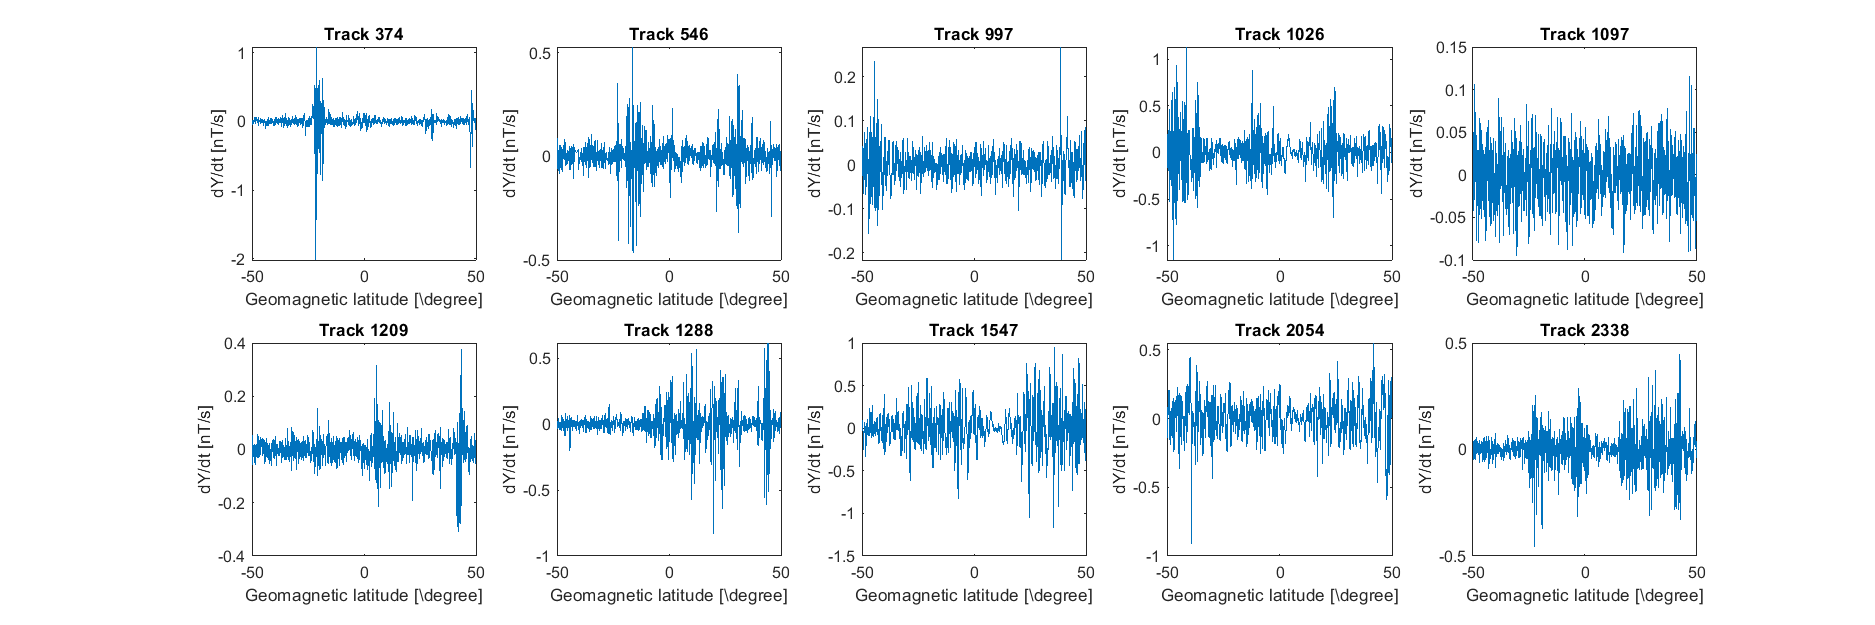

In [38]:
figure_index = fix(1+rand(10,1)*size(residuals,2));
figure_index = sortrows(figure_index);
figure('Position', [1, 1, 1500, 500])
for i=1:size(figure_index,1)
    latmag = residuals{figure_index(i)}.latmag;
    val = residuals{figure_index(i)}.residual;
    subplot(2,5,i)
    %plot(latmag, d);
    %hold on;
    %plot(latmag, fitted_value)
    %xlabel('Geoamgnetic latitude [\degree]', 'Interpreter', 'latex');
    %ylabel('dY/dt [nT/s]');
    %title('Numerical derivative of Y component');
    %subplot(2,1,2)
    plot(latmag, val)
    ylabel('dY/dt [nT/s]');
    xlabel('Geomagnetic latitude [\degree]', 'Interpreter', 'latex');
    title(['Track ', num2str(figure_index(i), '%d')]);
end

The following section extracted the anomalous magnetic signal from the previous selected tracs. 

In [39]:
max_dst = 20;
max_ap = 10;
anomalous_windows = {};
k_window = 1;
anomalous_track = nan(size(residuals,2), 9);
i_anom_track = 1;
for i=1:size(residuals,2)
    latmag = residuals{i}.latmag;
    val = residuals{i}.residual;
    z = residuals{i}.track;
    geomag_indexes = residuals{i}.geomag_index;
    track_threshold = threshold*nanstd(val);
    number_of_anomalous_windows = 0;
    geomag_lat_start = -50;
    geomag_lat_end = +50;
    step = width_window / 5;
    window_center = geomag_lat_start;
    while window_center <= geomag_lat_end
        window_rms = nanstd(val(abs(latmag - window_center) <= width_window / 2));
        if window_rms > track_threshold && abs(geomag_indexes(1)) <= max_dst && geomag_indexes(2) <= max_ap
            number_of_anomalous_windows = number_of_anomalous_windows + 1;
            anomalous_windows{k_window,1}.latmag = window_center;
            anomalous_windows{k_window,1}.latgeo = nanmean(z(abs(latmag - window_center) <= width_window / 2, 9));
            anomalous_windows{k_window,1}.longeo = nanmean(z(abs(latmag - window_center) <= width_window / 2, 10));
            anomalous_windows{k_window,1}.time = nanmean(datenum(z(abs(latmag - window_center) <= width_window / 2, 2:7)));
            k_window =  + 1;
        end
        window_center = window_center + step;
    end
    if number_of_anomalous_windows > 0
        [~, index_sample] = min(abs(epilat - z(:,9))); %search the closest latitudinal sample to the epicenter
        anomalous_track(i_anom_track,:) = [z(index_sample,2:7), z(1,1), z(index_sample,10), number_of_anomalous_windows];
        i_anom_track = i_anom_track + 1;
    end
end
i_anom_track
anomalous_track = anomalous_track(1:i_anom_track-1,:);
anomalous_track = sortrows(anomalous_track);

i_anom_track =    113

## Visualization of the cumulative number of Swarm magnetic tracks

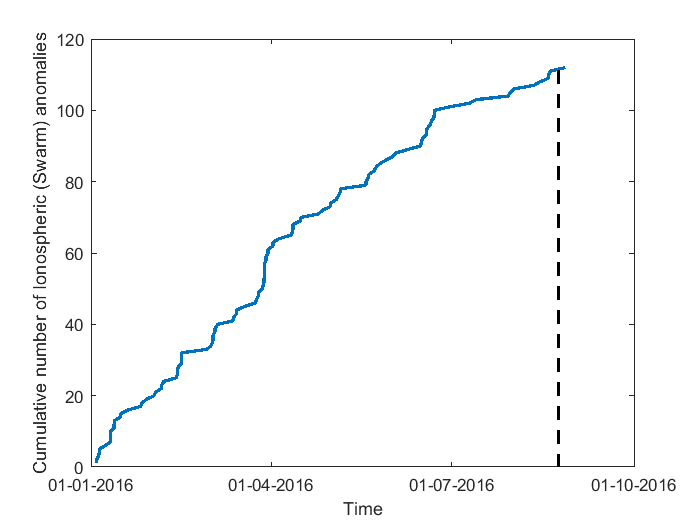

In [40]:
format compact
time_Swarm_anomalies = datenum(anomalous_track(:,1:6));
Cumulative_anomalies_Swarm = (1:size(anomalous_track,1))';
figure
plot(time_Swarm_anomalies, Cumulative_anomalies_Swarm, 'LineWidth', 2)
line([EQ_time, EQ_time], [0 Cumulative_anomalies_Swarm(end)], 'LineStyle', '--', 'LineWidth', 2, 'Color', 'k');
datetick('x', 'dd-mm-yyyy');
xlabel('Time');
ylabel('Cumulative number of Ionospheric (Swarm) anomalies');

# Comparison of Lithosphere, Atmosphere and Ionosphere analyses 

A final comparison of the analysed parameters is provided by the follwing code.  
The approach has been used in different earhtquake investigations in the World, as Mw = 7.5 Indonesia 2018, Mw = 7.7 Jamaica 2020, Mw = 7.1 Haiti 2021 or recent Mw = 6.8 Morocco 2023 earthquakes.  
**References:**
1. Marchetti, D. Observation of the Preparation Phase Associated with Mw = 7.2 Haiti Earthquake on 14 August 2021 from a Geophysical Data Point of View. Geosciences 2024, 14, 96. https://doi.org/10.3390/geosciences14040096

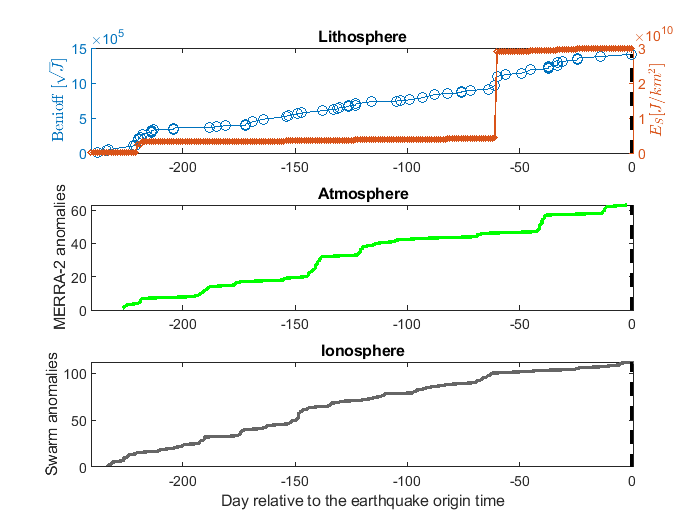

In [41]:
figure
subplot(3,1,1)
yyaxis left;
plot(time_EQ_sel - EQ_time, EQ_sqrt_energy, '-o');
line([0, 0], [0 EQ_sqrt_energy(end)], 'LineStyle', '--', 'LineWidth', 2, 'Color', 'k');
ylabel('Benioff [$\sqrt{J}$]', 'Interpreter', 'latex');
yyaxis right;
plot(cumulative_ES(:,1)- EQ_time, cumulative_ES(:,2), '-o', 'Linewidth', 1, 'MarkerSize', 2.5);
ylabel('$E_S [J/km^2]$', 'Interpreter', 'latex');
title(['Lithosphere']);
xlim([-day_before-1 day_after + 1]);
subplot(3,1,2)
plot(time_start-1+atmospheric_anomalies(:,1)-EQ_time, cumulate_atmosphere, 'g', 'LineWidth', 2)
line([0, 0], [0 cumulate_atmosphere(end)], 'LineStyle', '--', 'LineWidth', 2, 'Color', 'k');
ylabel('MERRA-2 anomalies');
xlim([-day_before-1 day_after + 1]);
title('Atmosphere')
subplot(3,1,3)
plot(time_Swarm_anomalies-EQ_time, Cumulative_anomalies_Swarm, 'Color', [0.4 0.4 0.4], 'LineWidth', 2)
line([0, 0], [0 Cumulative_anomalies_Swarm(end)], 'LineStyle', '--', 'LineWidth', 2, 'Color', 'k');
xlabel('Day relative to the earthquake origin time');
ylabel('Swarm anomalies');
title('Ionosphere')
xlim([-day_before-1 day_after + 1]);
